# Notebook: Metaphor analysis

This notebook is meant to analyse the metaphors detected by the REGEX and POS approaches.

The analysis will focus on:
- frequency of the word "inflation" related to the inflation rate
- Sentiment analysis of the metaphors flagged
- Poisson regression, with the metaphors sentiment score 

In [33]:
import re
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from ecbdata import ecbdata
from sklearn.preprocessing import MinMaxScaler
from transformers import pipeline
import matplotlib.colors as mcolors

from collections import Counter
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop = stopwords.words('english')

tqdm.pandas()

#ECB Color
color = (17/255, 49/255, 147/255)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\School\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
# Target words:
words_to_match = ["inflation","deflation","inflationary","desinflationary","hyperinflation","disinflation"]

In [35]:
# Functions

# Function to count the frequency of words from the list in a sentence
def count_frequency(answer, words_to_match):
    if pd.isna(answer):
        return 0
    sentence_lower = answer.lower()
    return sum(sentence_lower.count(word) for word in words_to_match)

# Function to remove stopwords
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in (stop)])
    return text

In [36]:
# Import dataset containing the interveiw data
df = pd.read_csv('Final_Working_Data_with_GPT_Output.csv')

# Convert 'date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# For computation speed, limit the data to the last 50 rows:
#df = df.tail(50)

start = df["Date"].min()
start = start.strftime('%Y-%m')
df2 = ecbdata.get_series('ICP.M.U2.N.000000.4.ANR', 
                        start=start)
df2["TIME_PERIOD"] = pd.to_datetime(df2["TIME_PERIOD"])
print("Start date is: ",start)

df.head()

Start date is:  2005-01


Unnamed: 0       Date                                              Media  \
0           0 2005-12-23                         Interview with Der Spiegel   
1           1 2005-12-19                  Interview with Hospodářské Noviny   
2           2 2005-12-19  Interview with Financial Times and Financial T...   
3           3 2005-12-15                         Interview with Paris Match   
4           4 2005-12-09                           Interview in Il Giornale   

                Member                                               Link  \
0  Jean-Claude Trichet  https://www.ecb.europa.eu/press/inter/date/200...   
1         Otmar Issing  https://www.ecb.europa.eu/press/inter/date/200...   
2      Lucas Papademos  https://www.ecb.europa.eu/press/inter/date/200...   
3  Jean-Claude Trichet  https://www.ecb.europa.eu/press/inter/date/200...   
4  Lorenzo Bini Smaghi  https://www.ecb.europa.eu/press/inter/date/200...   

             Information                                          Questions  \
0  Information not found  SPIEGEL: Monsieur Trichet, any concrete uttera...   
1  Information not found  The new EU member states want to adopt the eur...   
2  Information not found  Mr Papademos, you have responsibility as ECB V...   
3  Information not found  Paris Match. After two uneventful years at the...   
4  Information not found  However, Europe’s politicians, with few except...   

                                             Answers Metaphors  \
0  The publication of the translation was authori...       NaN   
1  These questions are all closely related to eac...       NaN   
2  A comparison of the risks involved when short-...       NaN   
3  The publication of the translation was authori...       NaN   
4  By Angelo Allegri, our correspondent in Frankf...       NaN   

  Metaphors Sentence  ...  list_regex_len list_regex_reduced_len text_length  \
0                NaN  ...               3                      3        9371   
1                NaN  ...               1                      1        3209   
2                NaN  ...              11                     10       16231   
3                NaN  ...               5                      4        8186   
4                NaN  ...               7                      7        6765   

                                      pos_metaphors pos_metaphors_len  \
0                                                []                 0   
1                                                []                 0   
2  [('low', 'inflation'), ('current', 'inflation')]                 2   
3                                                []                 0   
4                                                []                 0   

                                           Sentences  Frequency  \
0  ['We will in the future take the decisions tha...          5   
1  ['We are not confronted with deflation but wit...          1   
2  ['If longterm interest rates remain at a low l...         18   
3  ['You are exaggerating the increase in the cos...          7   
4  ['The rise has helped to keep inflation expect...          7   

   Sentences_len                                       Sentence_GPT  \
0              3  ['we will in the future take the decisions tha...   
1              1  ['we are not confronted with deflation but wit...   
2             11  ['if longterm interest rates remain at a low l...   
3              5  ['you are exaggerating the increase in the cos...   
4              7  ['the rise has helped to keep inflation expect...   

                                        Category_GPT  
0                    ['machine', 'disease', 'plant']  
1                                        ['warfare']  
2  ['orientation', 'orientation', 'plant', 'orien...  
3  ['plant', 'disease', 'other', 'disease', 'mach...  
4  ['orientation', 'orientation', 'orientation', ...  

[5 rows x 26 columns]

In [37]:
print("Shape of the dataset before dropping missing values: ", df.shape)
df.isna().sum()

Shape of the dataset before dropping missing values:  (519, 26)


Unnamed: 0                  0
Date                        0
Media                       0
Member                      0
Link                        0
Information                 0
Questions                  51
Answers                    10
Metaphors                 451
Metaphors Sentence        451
YoB                         0
Gender                      0
Country                     0
Period on the Board         0
list_regex                  0
list_regex_reduced          0
list_regex_len              0
list_regex_reduced_len      0
text_length                 0
pos_metaphors               0
pos_metaphors_len           0
Sentences                   0
Frequency                   0
Sentences_len               0
Sentence_GPT                0
Category_GPT                0
dtype: int64

In [38]:
print("Shape of the dataset after dropping missing values: ", df.shape)
df.nunique()

Shape of the dataset after dropping missing values:  (519, 26)


Unnamed: 0                519
Date                      489
Media                     259
Member                     19
Link                      519
Information               361
Questions                 465
Answers                   509
Metaphors                  59
Metaphors Sentence         59
YoB                        15
Gender                      2
Country                    10
Period on the Board        14
list_regex                407
list_regex_reduced        407
list_regex_len             38
list_regex_reduced_len     38
text_length               504
pos_metaphors             177
pos_metaphors_len          15
Sentences                 406
Frequency                  43
Sentences_len              34
Sentence_GPT              402
Category_GPT              310
dtype: int64

In [39]:
#types of data
df.dtypes

Unnamed: 0                         int64
Date                      datetime64[ns]
Media                             object
Member                            object
Link                              object
Information                       object
Questions                         object
Answers                           object
Metaphors                         object
Metaphors Sentence                object
YoB                                int64
Gender                            object
Country                           object
Period on the Board               object
list_regex                        object
list_regex_reduced                object
list_regex_len                     int64
list_regex_reduced_len             int64
text_length                        int64
pos_metaphors                     object
pos_metaphors_len                  int64
Sentences                         object
Frequency                          int64
Sentences_len                      int64
Sentence_GPT    

In [40]:
"""
# Run only once: The data will be saved in the right format afterwards.

# lambda function to convert string representations of lists into actual lists
parse_list = lambda x: ast.literal_eval(x) if isinstance(x, str) and x != '[\'None\']' else []
df.loc[:, 'Metaphors'] = df['Metaphors'].apply(parse_list)

# lambda function to count the elements in each list
df.loc[:, 'Metaphors_len'] = df['Metaphors'].apply(len)"""

"\n# Run only once: The data will be saved in the right format afterwards.\n\n# lambda function to convert string representations of lists into actual lists\nparse_list = lambda x: ast.literal_eval(x) if isinstance(x, str) and x != '['None']' else []\ndf.loc[:, 'Metaphors'] = df['Metaphors'].apply(parse_list)\n\n# lambda function to count the elements in each list\ndf.loc[:, 'Metaphors_len'] = df['Metaphors'].apply(len)"

In [41]:
# function to convert string representations of lists into actual lists
parse_list = lambda x: ast.literal_eval(x) if x != '[]' else []
df.loc[:, 'Sentence_GPT'] = df['Sentence_GPT'].apply(parse_list)

df['GPT_Length'] = df['Sentence_GPT'].apply(len)

# EDA on the (human) labeled data

In [42]:
# Dataframe with the labeled Metaphors
df_labels = df[df['Metaphors'].notnull()].copy()
print("Shape of the dataset with labeled Metaphors: ", df_labels.shape)

Shape of the dataset with labeled Metaphors:  (68, 27)


In [43]:
df_labels.isna().sum()

Unnamed: 0                0
Date                      0
Media                     0
Member                    0
Link                      0
Information               0
Questions                 6
Answers                   0
Metaphors                 0
Metaphors Sentence        0
YoB                       0
Gender                    0
Country                   0
Period on the Board       0
list_regex                0
list_regex_reduced        0
list_regex_len            0
list_regex_reduced_len    0
text_length               0
pos_metaphors             0
pos_metaphors_len         0
Sentences                 0
Frequency                 0
Sentences_len             0
Sentence_GPT              0
Category_GPT              0
GPT_Length                0
dtype: int64

In [44]:
# lambda function to convert string representations of lists into actual lists
parse_list = lambda x: ast.literal_eval(x) if x != '[\'None\']' else []
df_labels.loc[:, 'Metaphors'] = df_labels['Metaphors'].apply(parse_list)

# lambda function to count the elements in each list
df_labels.loc[:, 'Metaphors_len'] = df_labels['Metaphors'].apply(len)

In [45]:
# Count the frequency of words from the list words_to_match
df_labels["Frequency"] = df_labels["Answers"].apply(count_frequency, words_to_match=words_to_match)

In [46]:
df_labels.head()

Unnamed: 0       Date                                              Media  \
47          47 2009-09-12  Interview with the "Junge Zeitung“ of the Fran...   
65          65 2010-04-24                            Interview with Expresso   
73          73 2011-10-18      Interview with Frankfurter Allgemeine Zeitung   
79          79 2011-09-20                           Interview with Expansión   
85          85 2011-06-16                           Interview with The Times   

                 Member                                               Link  \
47  Jean-Claude Trichet  https://www.ecb.europa.eu/press/inter/date/200...   
65  Jean-Claude Trichet  https://www.ecb.europa.eu/press/inter/date/201...   
73  Jean-Claude Trichet  https://www.ecb.europa.eu/press/inter/date/201...   
79  Jean-Claude Trichet  https://www.ecb.europa.eu/press/inter/date/201...   
85  Jean-Claude Trichet  https://www.ecb.europa.eu/press/inter/date/201...   

              Information                                          Questions  \
47  Information not found                                                NaN   
65  Information not found  Are we really leaving the crisis behind or are...   
73  Information not found  Mr Trichet, do you believe in destiny?[end_que...   
79  Information not found  1. At the last meeting you said that the risks...   
85  Information not found  The Times: There are two camps: one that empha...   

                                              Answers  \
47  Mr. President, as „Mr. Euro“: How many Euros d...   
65  As regards the conjuncture in the real economy...   
73  I have used that term on a few occasions – inc...   
79  At the last meeting of the Governing Council w...   
85  Jean-Claude Trichet: All advanced economies ar...   

                                            Metaphors  \
47  [fear deflation, inflation below, preserved th...   
65                                                 []   
73  [experience of hyperinflationr, experienced hy...   
79  [upside risks to inflation, materialisation of...   
85  [anchor very solidly inflation, materialisatio...   

                                   Metaphors Sentence  ...  text_length  \
47  ['Or does the ECB fear deflation', 'Our defini...  ...        11198   
65                                           ['None']  ...        12101   
73  ['As regards inflation, I understand the deep-...  ...        12782   
79  ['On the other hand, in July there were upside...  ...         7295   
85  ['What I would say is that in our case it is v...  ...        10455   

                pos_metaphors pos_metaphors_len  \
47                         []                 0   
65                         []                 0   
73  [('annual', 'inflation')]                 1   
79                         []                 0   
85  [('annual', 'inflation')]                 1   

                                            Sentences Frequency Sentences_len  \
47  ['At the moment there is no inflation.', 'Can ...         7             5   
65                                                 []         0             0   
73  ['Average annual inflation has at 2.0 over the...         9             6   
79  ['On the other hand in July there were upside ...         3             2   
85  ['Annual average inflation over the past 12 ye...        12             6   

                                         Sentence_GPT  \
47  [since the inception of the single currency we...   
65                                                 []   
73  [as regards inflation i understand the deepsea...   
79  [on the other hand in july there were upside r...   
85  [what i would say is that in our case it is ve...   

                                         Category_GPT  GPT_Length  \
47                              ['warfare', 'sports']           2   
65                                                 []           0   
73                         ['disease', 'orientation']           2   
79                     

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

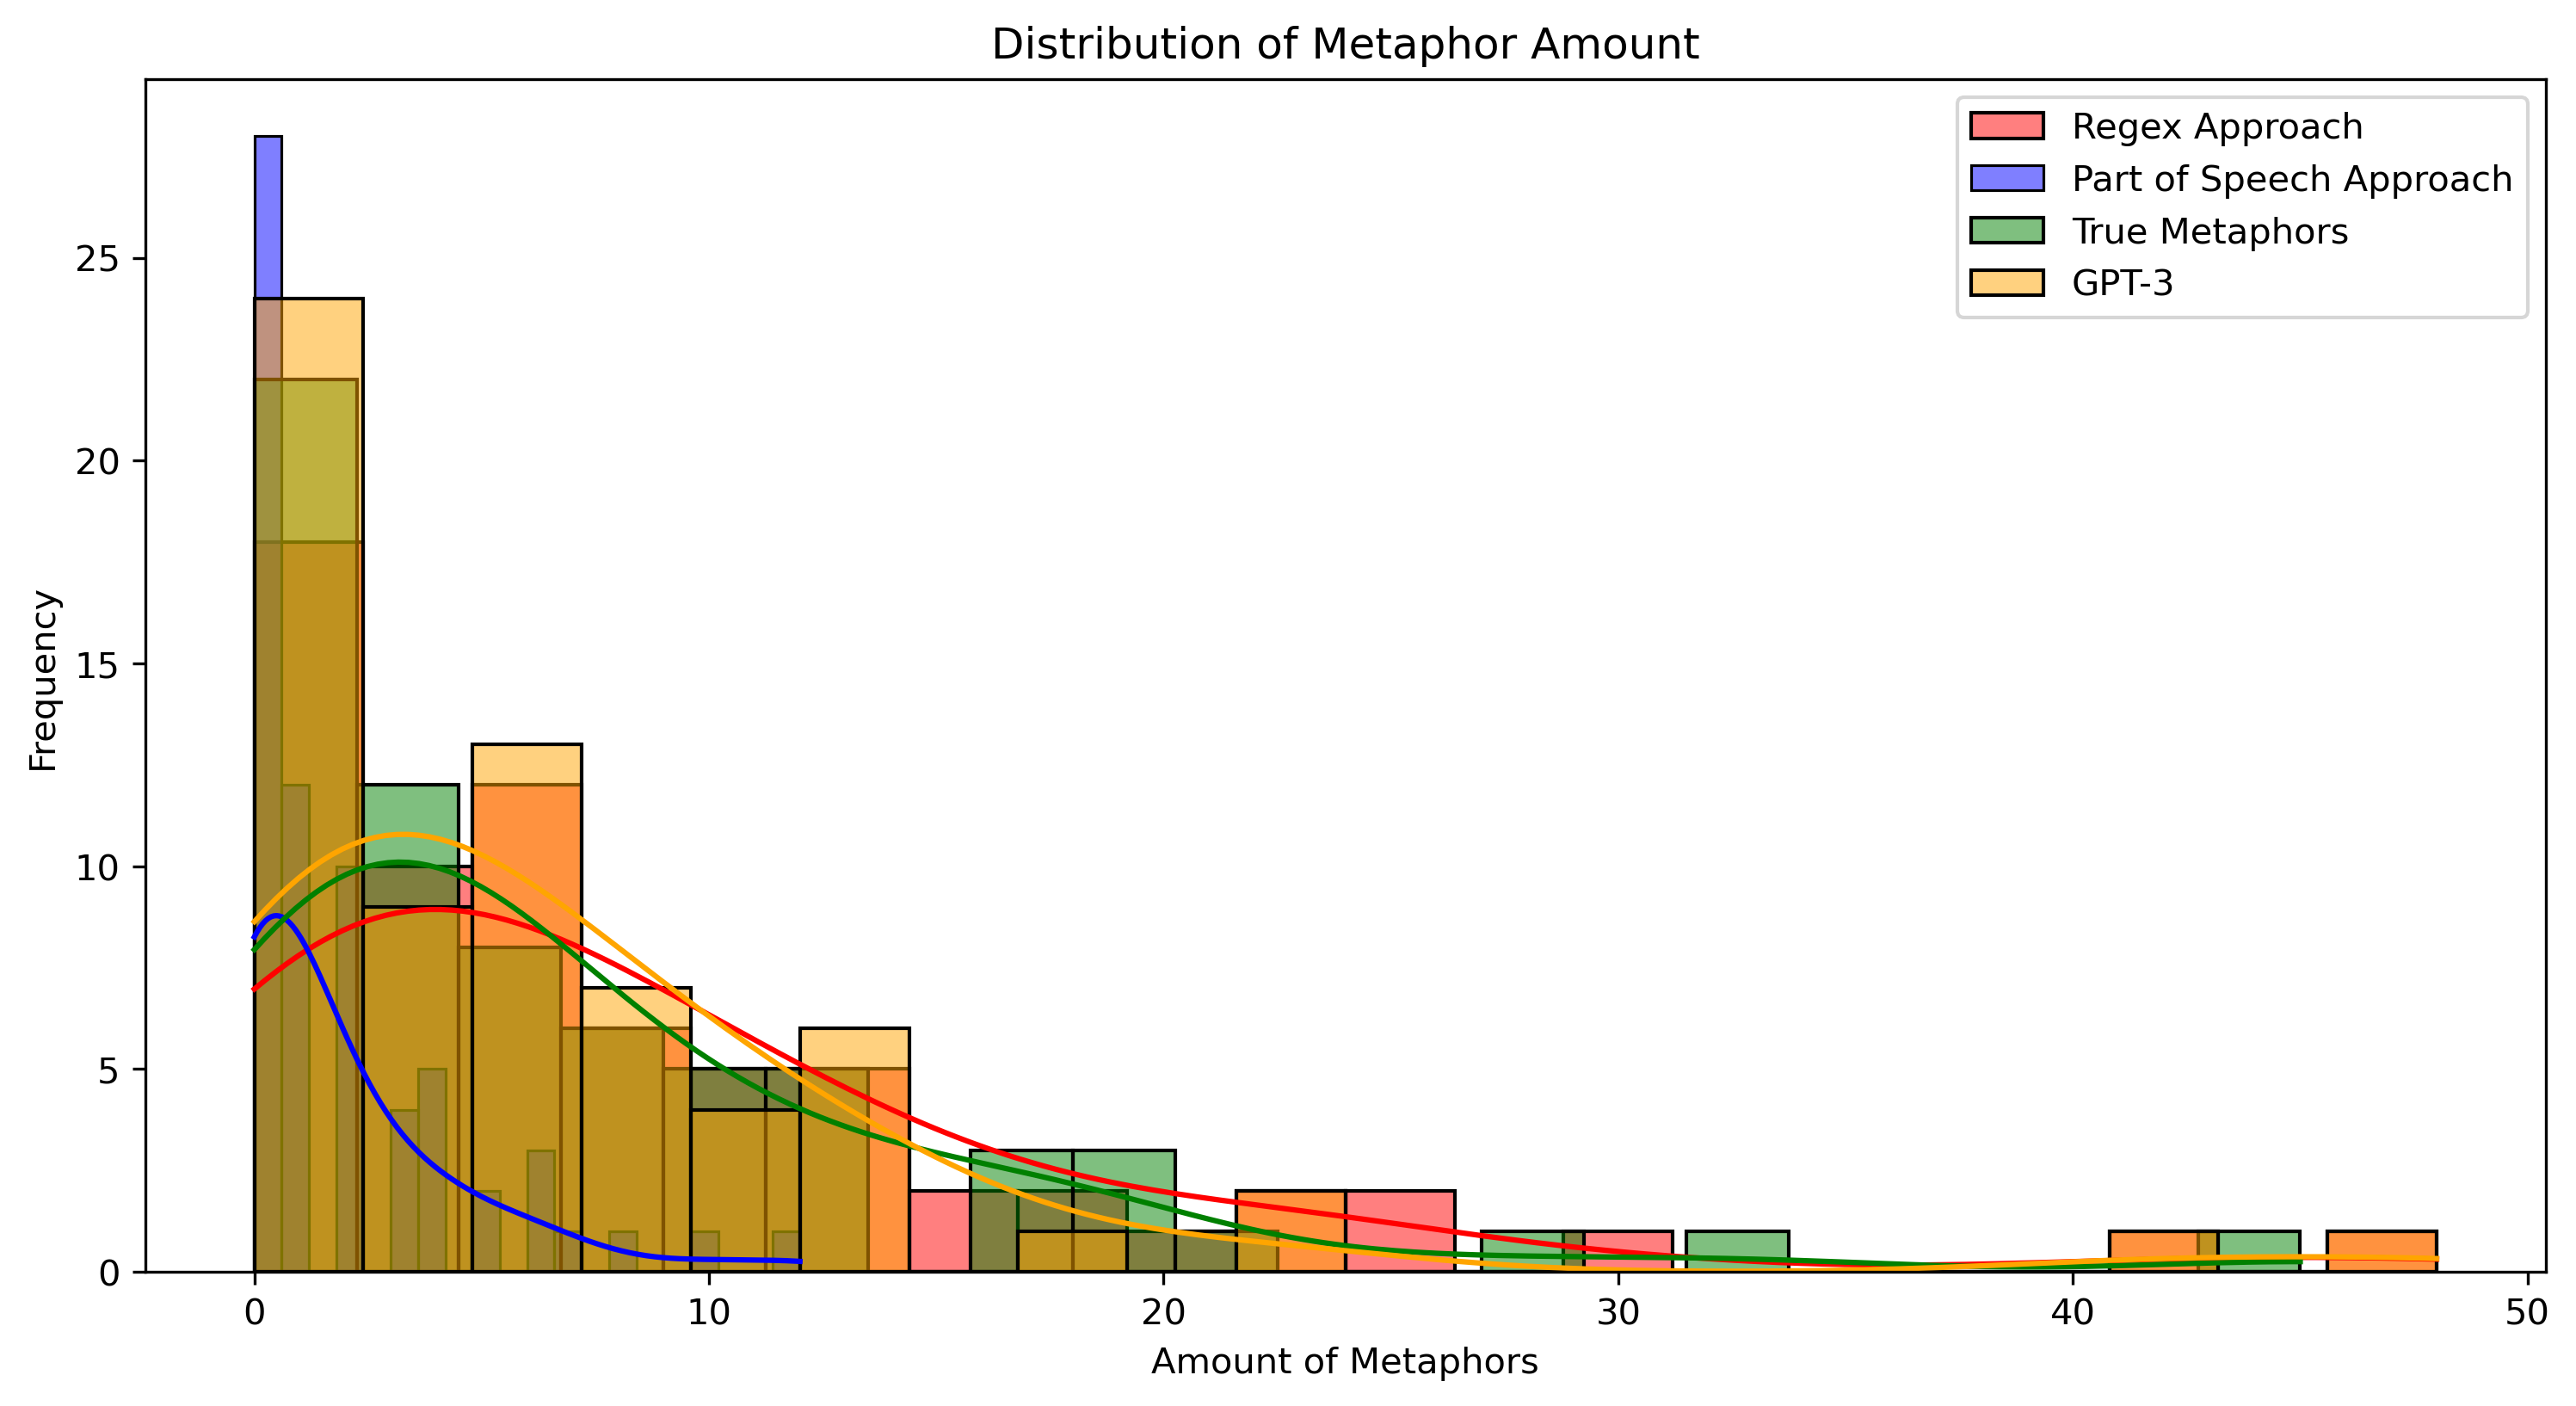

In [47]:
plt.figure(figsize=(12, 6),dpi=300)
sns.histplot(data=df_labels, x='list_regex_reduced_len', bins=20, kde=True, color='red', label='Regex Approach')
sns.histplot(data=df_labels, x='pos_metaphors_len', bins=20, kde=True, color='blue', label='Part of Speech Approach')
sns.histplot(data=df_labels, x='Metaphors_len', bins=20, kde=True, color='green', label='True Metaphors')
sns.histplot(data=df_labels, x='GPT_Length', bins=20, kde=True, color='orange', label='GPT-3')
plt.title('Distribution of Metaphor Amount')
plt.xlabel('Amount of Metaphors')
plt.ylabel('Frequency')
plt.legend()
plt.show()

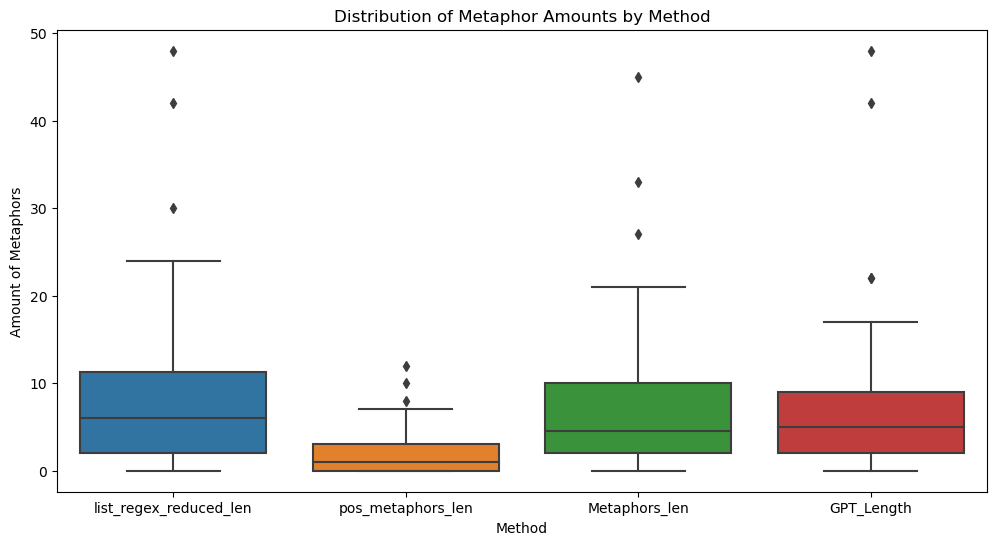

In [48]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_labels[['list_regex_reduced_len', 'pos_metaphors_len', 'Metaphors_len', 'GPT_Length']])
plt.title('Distribution of Metaphor Amounts by Method')
plt.xlabel('Method')
plt.ylabel('Amount of Metaphors')
plt.show()

In [49]:
# Order the "Metaphor_len" and print top 5
df_labels.sort_values(by='Metaphors_len', ascending=False).head()

Unnamed: 0       Date                                              Media  \
509         509 2023-01-17                     Interview with Financial Times   
483         483 2023-09-05                        Interview with The Currency   
439         439 2022-11-21                         Interview with Market News   
316         316 2020-12-02  Transcript of the fireside chat at Reuters Glo...   
172         172 2015-03-25                      Interview with Il Sole 24 Ore   

             Member                                               Link  \
509  Philip R. Lane  https://www.ecb.europa.eu/press/inter/date/202...   
483  Philip R. Lane  https://www.ecb.europa.eu/press/inter/date/202...   
439  Philip R. Lane  https://www.ecb.europa.eu/press/inter/date/202...   
316  Philip R. Lane  https://www.ecb.europa.eu/press/inter/date/202...   
172     Peter Praet  https://www.ecb.europa.eu/press/inter/date/201...   

                                           Information  \
509  Interview with Philip R. Lane, Member of the E...   
483  Interview with Philip R. Lane, Member of the E...   
439  Interview with Philip R. Lane, Member of the E...   
316  Interview with Philip R. Lane, Member of the E...   
172                              Information not found   

                                             Questions  \
509  From your perspective, how much do you see the...   
483  Let’s dive straight in and talk about the broa...   
439  What do you expect December’s Eurosystem growt...   
316  The pandemic has of course dominated your year...   
172  In the ECB latest projections, as in those of ...   

                                               Answers  \
509  17 January 2023[end_answer] The way to think a...   
483  5 September 2023[end_answer] We’re speaking to...   
439  21 November 2022[end_answer] The staff project...   
316  2 December 2020[end_answer] As you indicate, w...   
172  After two recessions, the first in 2009 and an...   

                                             Metaphors  \
509  [inflationary pressure, inflationary environme...   
483  [inflation came down, inflation come down, inf...   
439  [inflation is higher, starting point for infla...   
316  [shock to inflation, convergence of inflation,...   
172  [inflation was remaining weak, inflation expec...   

                                    Metaphors Sentence  ...  text_length  \
509  ['For me the way to differentiate these narrat...  ...        25435   
483  ['So goods inflation and services inflation ca...  ...        28488   
439  ['Number one, inflation is higher now than was...  ...        18889   
316  ['So, if we can keep financing conditions wher...  ...        19777   
172  ['Then, in November, we saw that inflation was...  ...        12887   

                                         pos_metaphors pos_metaphors_len  \
509  [('inflation', 'come'), ('inflation', 'fight')...                12   
483  [('inflation', 'come'), ('inflation', 'come'),...                10   
439  [('inflation', 'come'), ('inflation', 'go'), (...                 5   
316       [('inflation', 'get'), ('low', 'inflation')]                 2   
172  [('annual', 'inflation'), ('core', 'inflation'...                 3   

                                             Sentences Frequency  \
509  ['Theres a large global component to inflation...        68   
483  ['Of course in any given month the change is r...        56   
439  ['Number one inflation is higher now than was ...        33   
316  ['So if we can keep financing conditions where...        23   
172  ['Then in November we saw that inflation was r...        24   

    Sentences_len                                       Sentence_GPT  \
509            48  [for me the way to differentiate these narrati...   
483            42  [of course in any given month the change is re...   
439            30  [even if this does not have an immediate effec...   
316            20  [its very difficult to live with a reversal of.

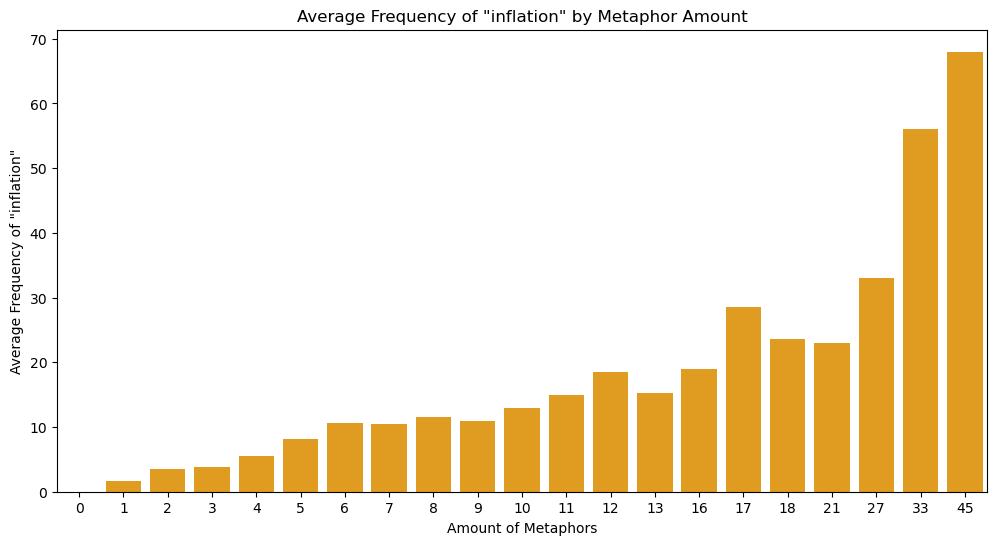

In [50]:
avg_freq_by_length = df_labels.groupby('Metaphors_len')['Frequency'].mean()
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_freq_by_length.index, y=avg_freq_by_length.values, color='orange')
plt.title('Average Frequency of "inflation" by Metaphor Amount')
plt.xlabel('Amount of Metaphors')
plt.ylabel('Average Frequency of "inflation"')
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


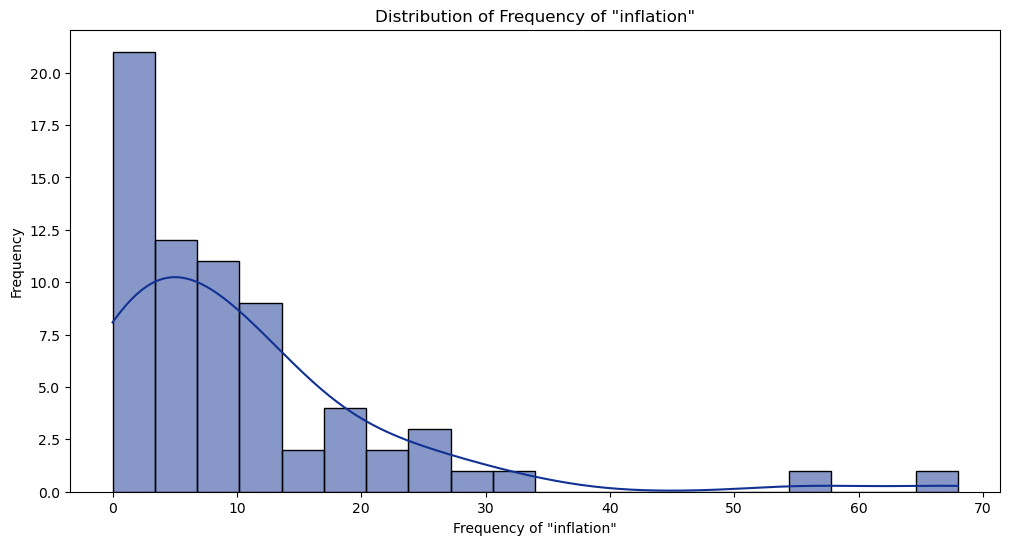

In [51]:
# Plot the Frequency 
plt.figure(figsize=(12, 6))
sns.histplot(data=df_labels, x='Frequency', bins=20, kde=True, color=color)
plt.title('Distribution of Frequency of "inflation"')
plt.xlabel('Frequency of "inflation"')
plt.ylabel('Frequency')
plt.show()


## Metrics: basic appraoches vs human label

COMPARES ONLY THE AMOUNT OF METAPHORS DETECTED? NOT IF THEY ARE THE SAME

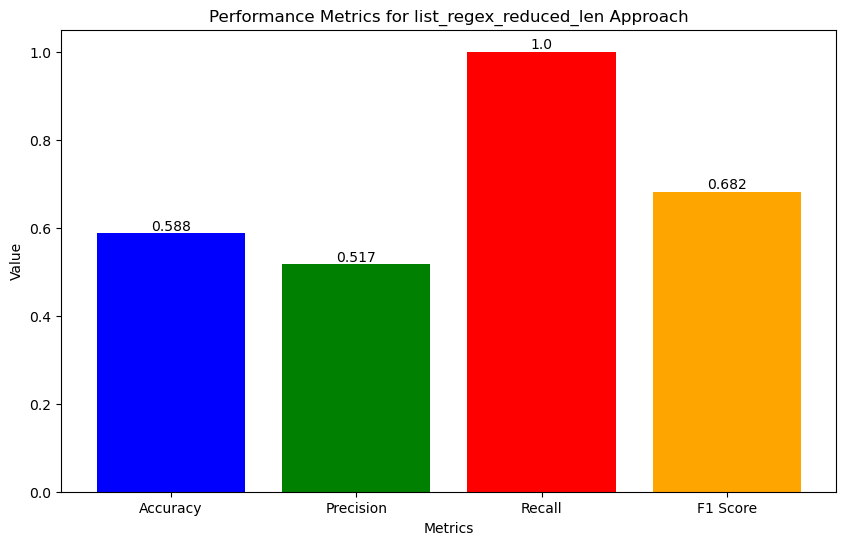

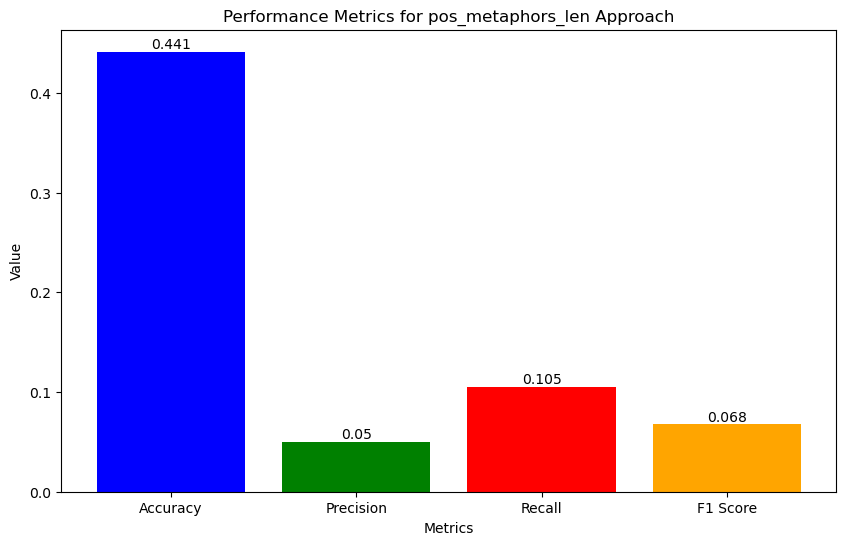

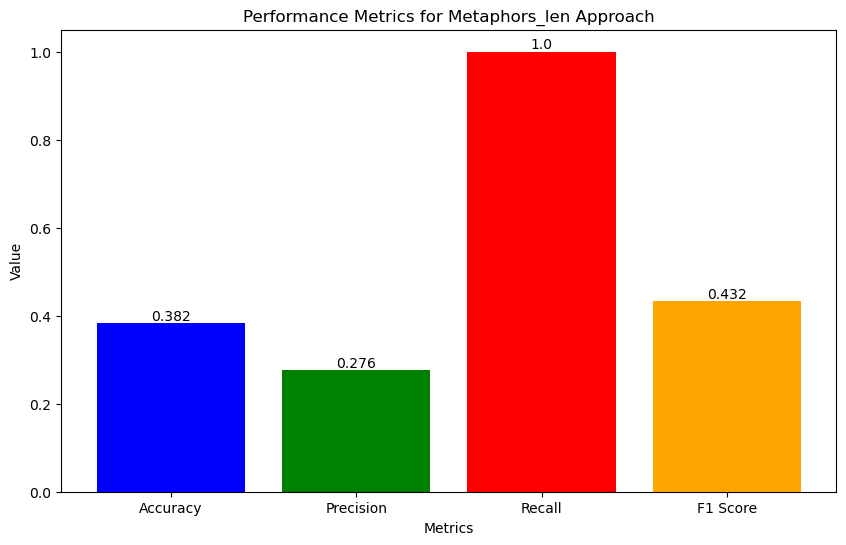

In [52]:
def evaluate_approach(df, approach):
    # Compute metrics for the given approach
    true_positives = ((df[approach] != 0) & (df['GPT_Length'] == df[approach])).sum()
    false_positives = ((df[approach] != 0) & (df['GPT_Length'] != df[approach])).sum()
    false_negatives = ((df[approach] == 0) & (df['GPT_Length'] != 0)).sum()

    # Calculate metrics
    accuracy = (true_positives + (df[approach] == 0).sum()) / len(df)
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    # Plot results
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    values = [accuracy, precision, recall, f1_score]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(metrics, values, color=['blue', 'green', 'red', 'orange'])
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    plt.title(f'Performance Metrics for {approach} Approach')

    # Annotate bars with values
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, value, round(value, 3), 
                 ha='center', va='bottom')

    plt.show()

evaluate_approach(df_labels, 'list_regex_reduced_len')
evaluate_approach(df_labels, 'pos_metaphors_len')
evaluate_approach(df_labels, 'Metaphors_len')

# EDA on the (GPT) labeled data

In [53]:
# Add Ratio of Metaphors to the dataframe, Frequency / text length
df['Ratio'] = df['Frequency'] / df['text_length']
df.head()

Unnamed: 0       Date                                              Media  \
0           0 2005-12-23                         Interview with Der Spiegel   
1           1 2005-12-19                  Interview with Hospodářské Noviny   
2           2 2005-12-19  Interview with Financial Times and Financial T...   
3           3 2005-12-15                         Interview with Paris Match   
4           4 2005-12-09                           Interview in Il Giornale   

                Member                                               Link  \
0  Jean-Claude Trichet  https://www.ecb.europa.eu/press/inter/date/200...   
1         Otmar Issing  https://www.ecb.europa.eu/press/inter/date/200...   
2      Lucas Papademos  https://www.ecb.europa.eu/press/inter/date/200...   
3  Jean-Claude Trichet  https://www.ecb.europa.eu/press/inter/date/200...   
4  Lorenzo Bini Smaghi  https://www.ecb.europa.eu/press/inter/date/200...   

             Information                                          Questions  \
0  Information not found  SPIEGEL: Monsieur Trichet, any concrete uttera...   
1  Information not found  The new EU member states want to adopt the eur...   
2  Information not found  Mr Papademos, you have responsibility as ECB V...   
3  Information not found  Paris Match. After two uneventful years at the...   
4  Information not found  However, Europe’s politicians, with few except...   

                                             Answers Metaphors  \
0  The publication of the translation was authori...       NaN   
1  These questions are all closely related to eac...       NaN   
2  A comparison of the risks involved when short-...       NaN   
3  The publication of the translation was authori...       NaN   
4  By Angelo Allegri, our correspondent in Frankf...       NaN   

  Metaphors Sentence  ...  text_length  \
0                NaN  ...         9371   
1                NaN  ...         3209   
2                NaN  ...        16231   
3                NaN  ...         8186   
4                NaN  ...         6765   

                                      pos_metaphors pos_metaphors_len  \
0                                                []                 0   
1                                                []                 0   
2  [('low', 'inflation'), ('current', 'inflation')]                 2   
3                                                []                 0   
4                                                []                 0   

                                           Sentences Frequency Sentences_len  \
0  ['We will in the future take the decisions tha...         5             3   
1  ['We are not confronted with deflation but wit...         1             1   
2  ['If longterm interest rates remain at a low l...        18            11   
3  ['You are exaggerating the increase in the cos...         7             5   
4  ['The rise has helped to keep inflation expect...         7             7   

                                        Sentence_GPT  \
0  [we will in the future take the decisions that...   
1  [we are not confronted with deflation but with...   
2  [if longterm interest rates remain at a low le...   
3  [you are exaggerating the increase in the cost...   
4  [the rise has helped to keep inflation expecta...   

                                        Category_GPT  GPT_Length     Ratio  
0                    ['machine', 'disease', 'plant']           3  0.000534  
1                                        ['warfare']           1  0.000312  
2  ['orientation', 'orientation', 'plant', 'orien...          11  0.001109  
3  ['plant', 'disease', 'other', 'disease', 'mach...           5  0.000855  
4  ['orientation', 'orientation', 'orientation', ...           7  0.001035  

[5 rows x 28 columns]

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


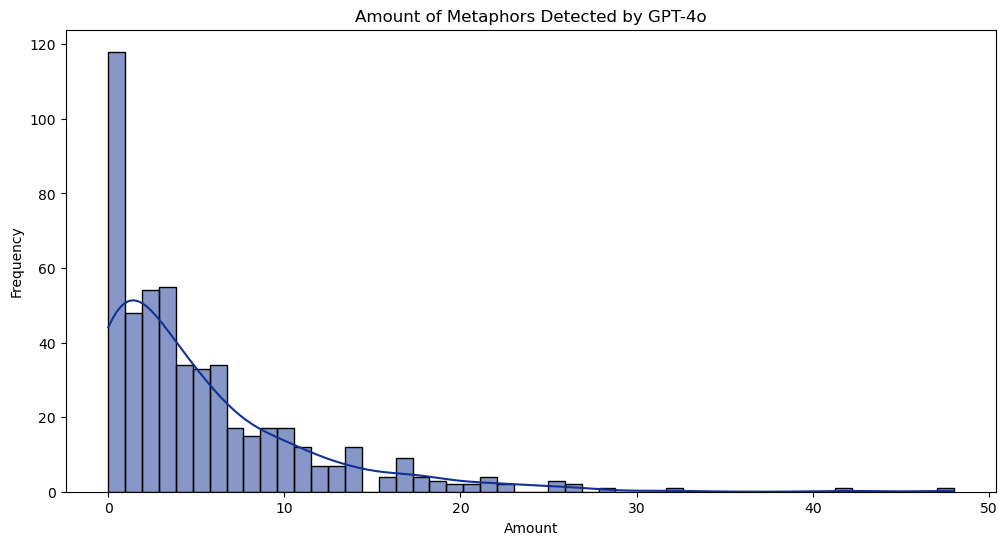

In [54]:
# Amount of Metaphors detected
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='GPT_Length', bins=50, kde=True, color=color)
plt.title('Amount of Metaphors Detected by GPT-4o')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


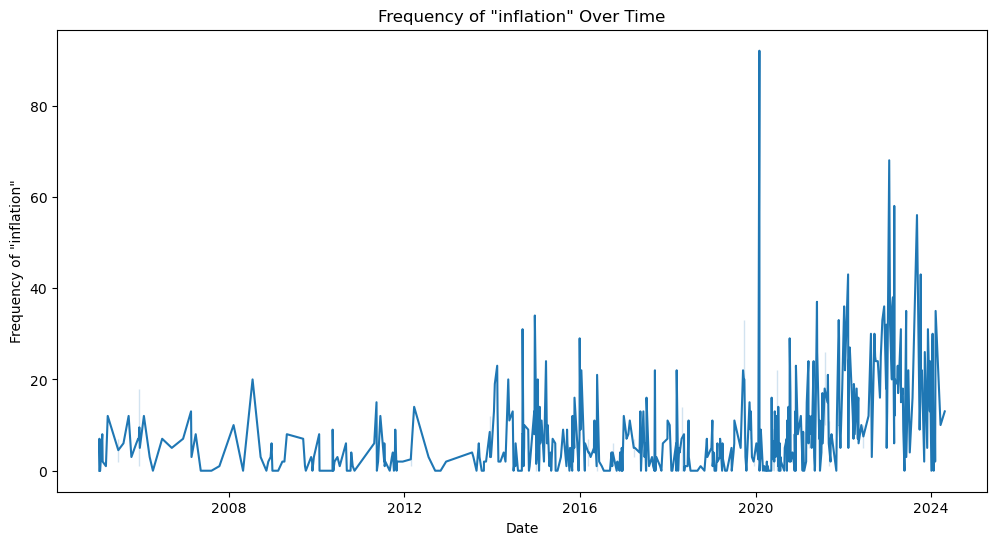

In [55]:
# Frequency of "inflation" Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Date', y='Frequency')
plt.title('Frequency of "inflation" Over Time')
plt.xlabel('Date')
plt.ylabel('Frequency of "inflation"')
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


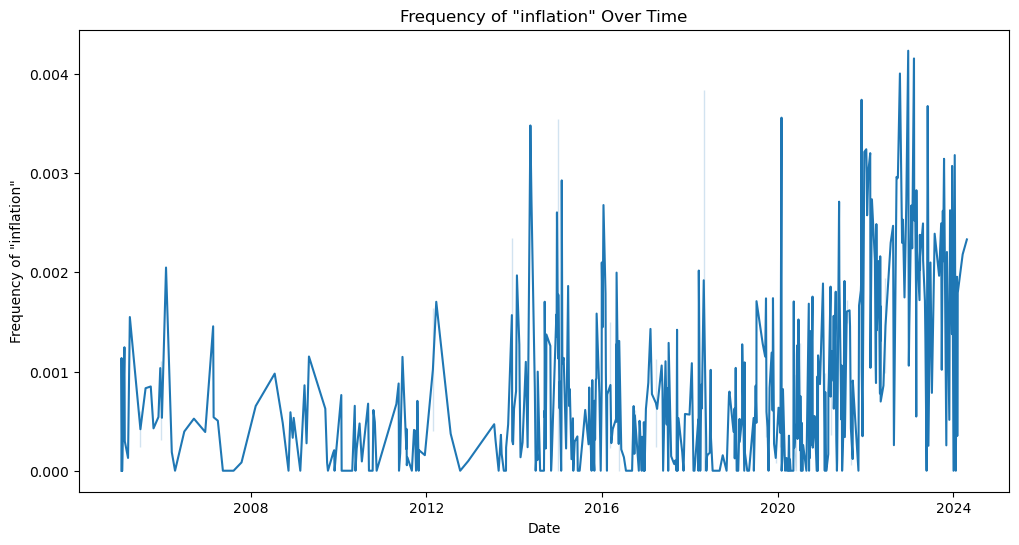

In [56]:
# Ratio over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Date', y='Ratio')
plt.title('Frequency of "inflation" Over Time')
plt.xlabel('Date')
plt.ylabel('Frequency of "inflation"')
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


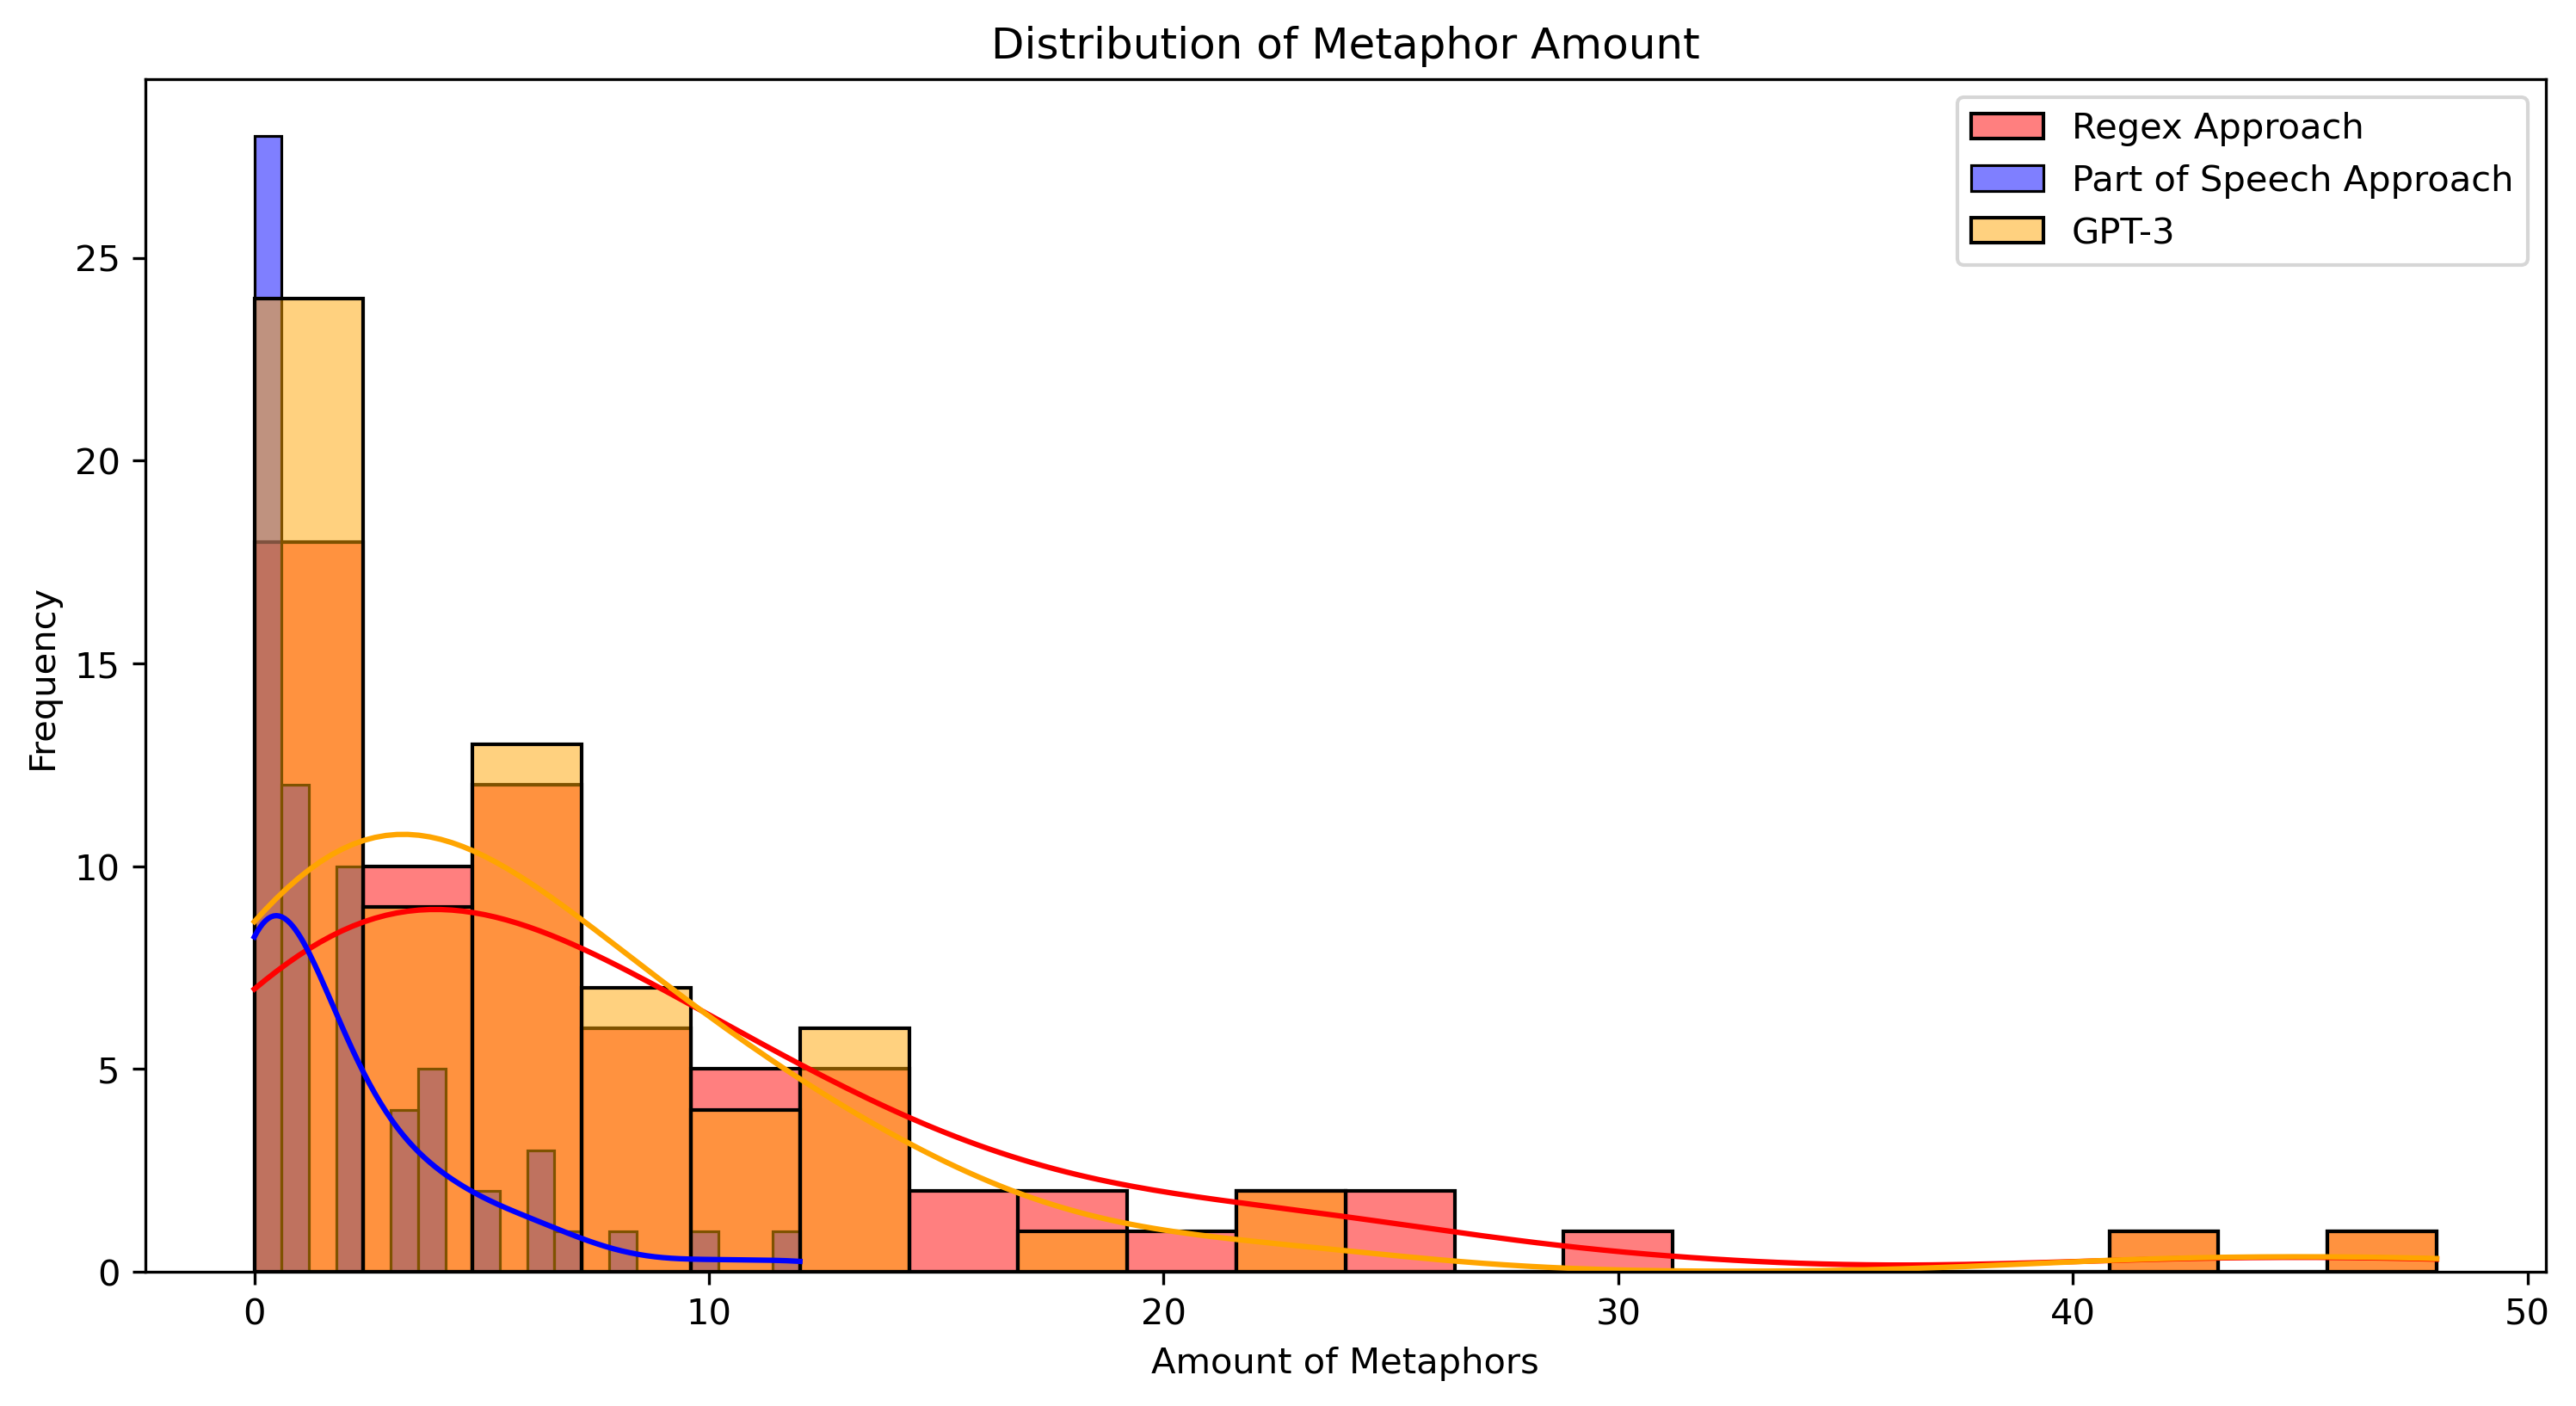

In [57]:
plt.figure(figsize=(12, 6),dpi=300)
sns.histplot(data=df_labels, x='list_regex_reduced_len', bins=20, kde=True, color='red', label='Regex Approach')
sns.histplot(data=df_labels, x='pos_metaphors_len', bins=20, kde=True, color='blue', label='Part of Speech Approach')
sns.histplot(data=df_labels, x='GPT_Length', bins=20, kde=True, color='orange', label='GPT-3')
plt.title('Distribution of Metaphor Amount')
plt.xlabel('Amount of Metaphors')
plt.ylabel('Frequency')
plt.legend()
plt.show()

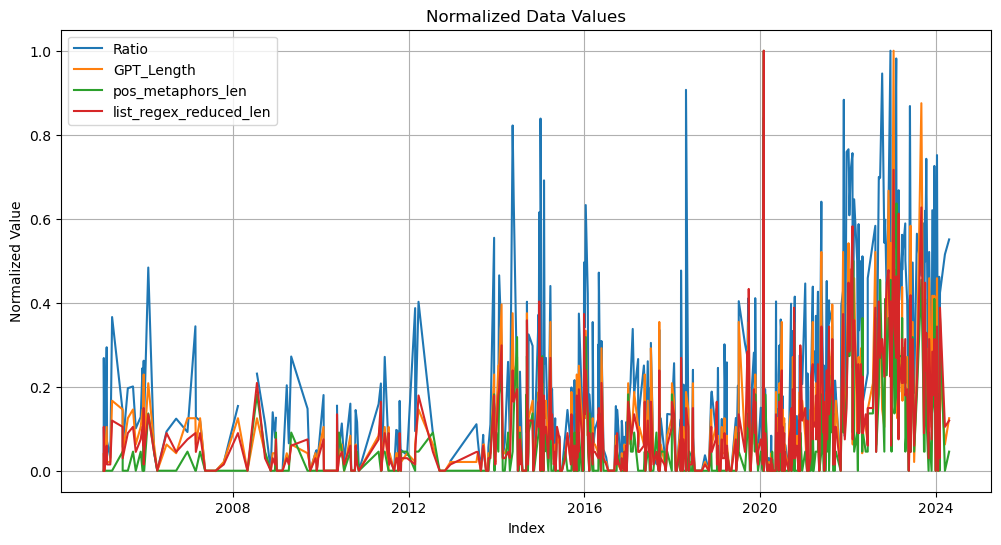

In [59]:
# Create a copy of the specified columns
columns_to_normalize = ['Date','Ratio','GPT_Length', 'pos_metaphors_len', 'list_regex_reduced_len']
df_copy = df[columns_to_normalize].copy()

# Set date as index
df_copy.set_index('Date', inplace=True)
# Ensure the DataFrame is sorted by date
df_copy.sort_index(inplace=True)

# Normalize the values in these columns
scaler = MinMaxScaler()
normalized_values = scaler.fit_transform(df_copy)

# Create a DataFrame with normalized values, keeping the Date as index
df_normalized = pd.DataFrame(normalized_values, columns=df_copy.columns, index=df_copy.index)

# Plot normalized values against each other
plt.figure(figsize=(12, 6))

for column in df_normalized.columns:
    plt.plot(df_normalized.index, df_normalized[column], label=column)

# Customize the plot
plt.xlabel('Index')
plt.ylabel('Normalized Value')
plt.title('Normalized Data Values')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [60]:
df_normalized.head()

Ratio  GPT_Length  pos_metaphors_len  list_regex_reduced_len
Date                                                                       
2005-01-20  0.000000    0.000000                0.0                0.000000
2005-01-21  0.268241    0.041667                0.0                0.104478
2005-01-27  0.000000    0.000000                0.0                0.000000
2005-02-14  0.293968    0.104167                0.0                0.059701
2005-02-17  0.070204    0.020833                0.0                0.014925

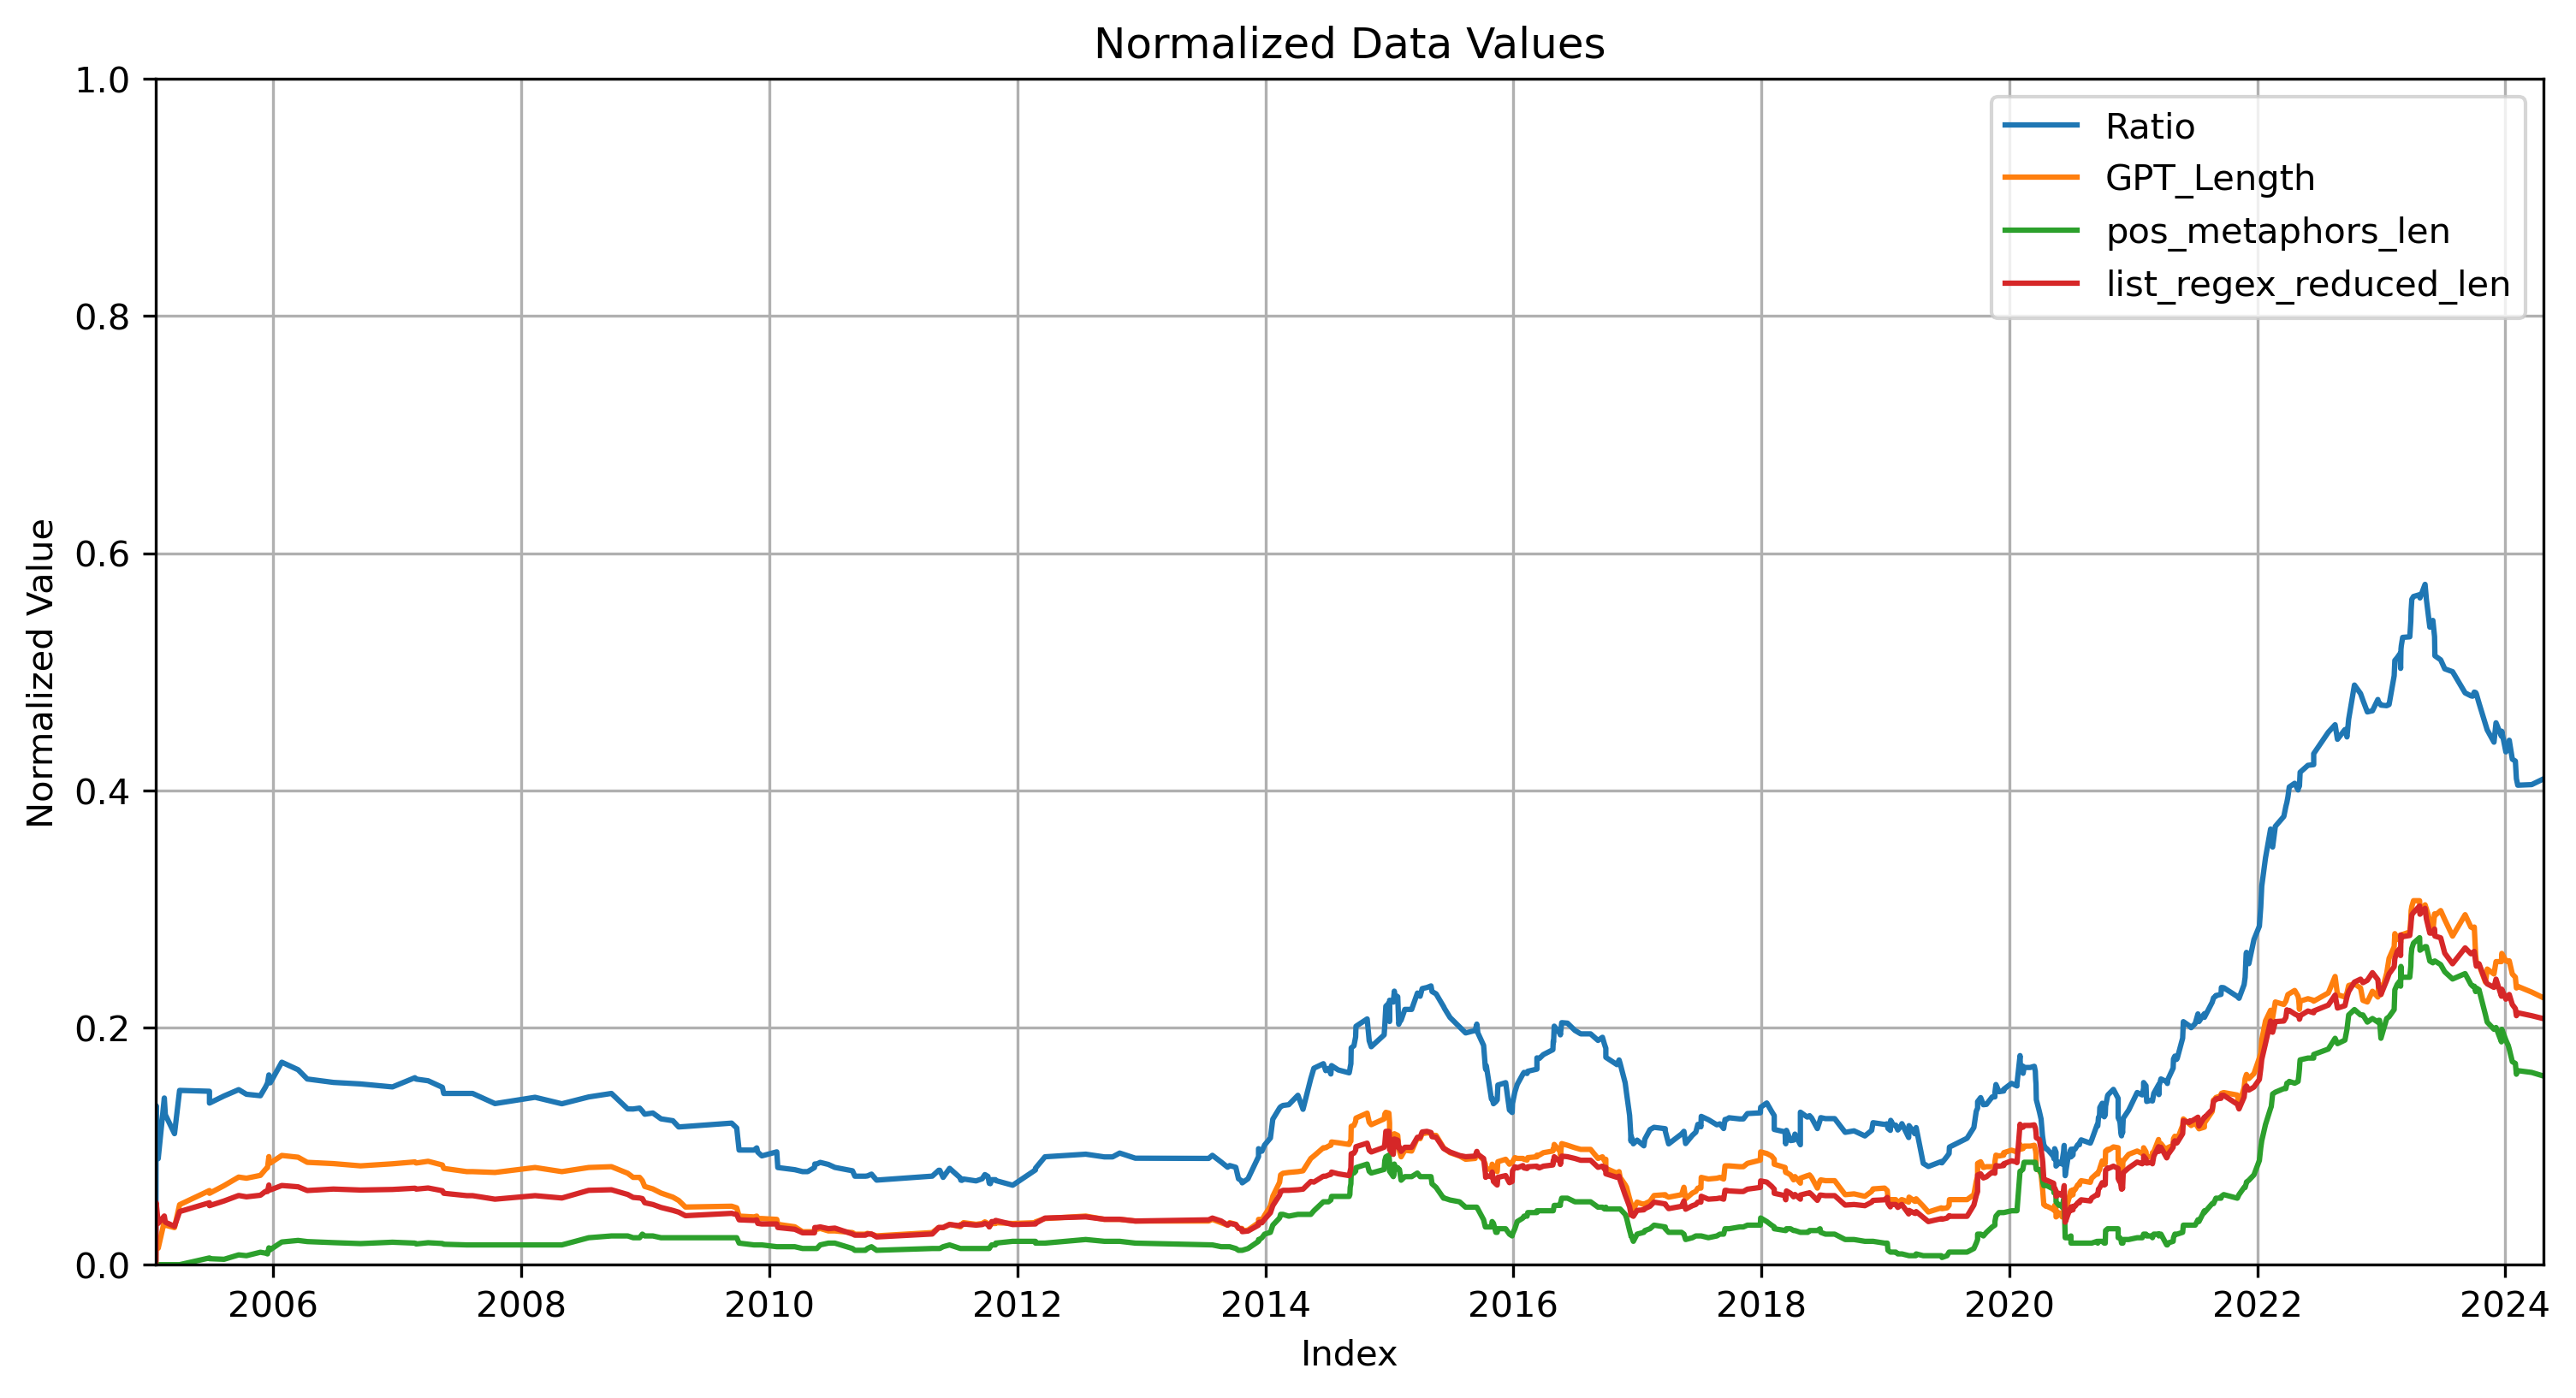

In [61]:
# Smooth plot:
def moving_average(data, window_size):
    return data.rolling(window=window_size, min_periods=1).mean()

plt.figure(figsize=(12, 6),dpi=300)
# Apply moving average to smooth the lines
window_size = 30

for column in df_normalized.columns:
    plt.plot(df_normalized.index, moving_average(df_normalized[column], window_size), label=column)


# Customize the plot
plt.xlabel('Index')
plt.ylabel('Normalized Value')
plt.title('Normalized Data Values')
plt.legend()
plt.grid(True)

# Set the x-axis and y-axis limits
plt.xlim(df_normalized.index.min(), df_normalized.index.max())
plt.ylim(0, 1)

# Display the plot
plt.show()

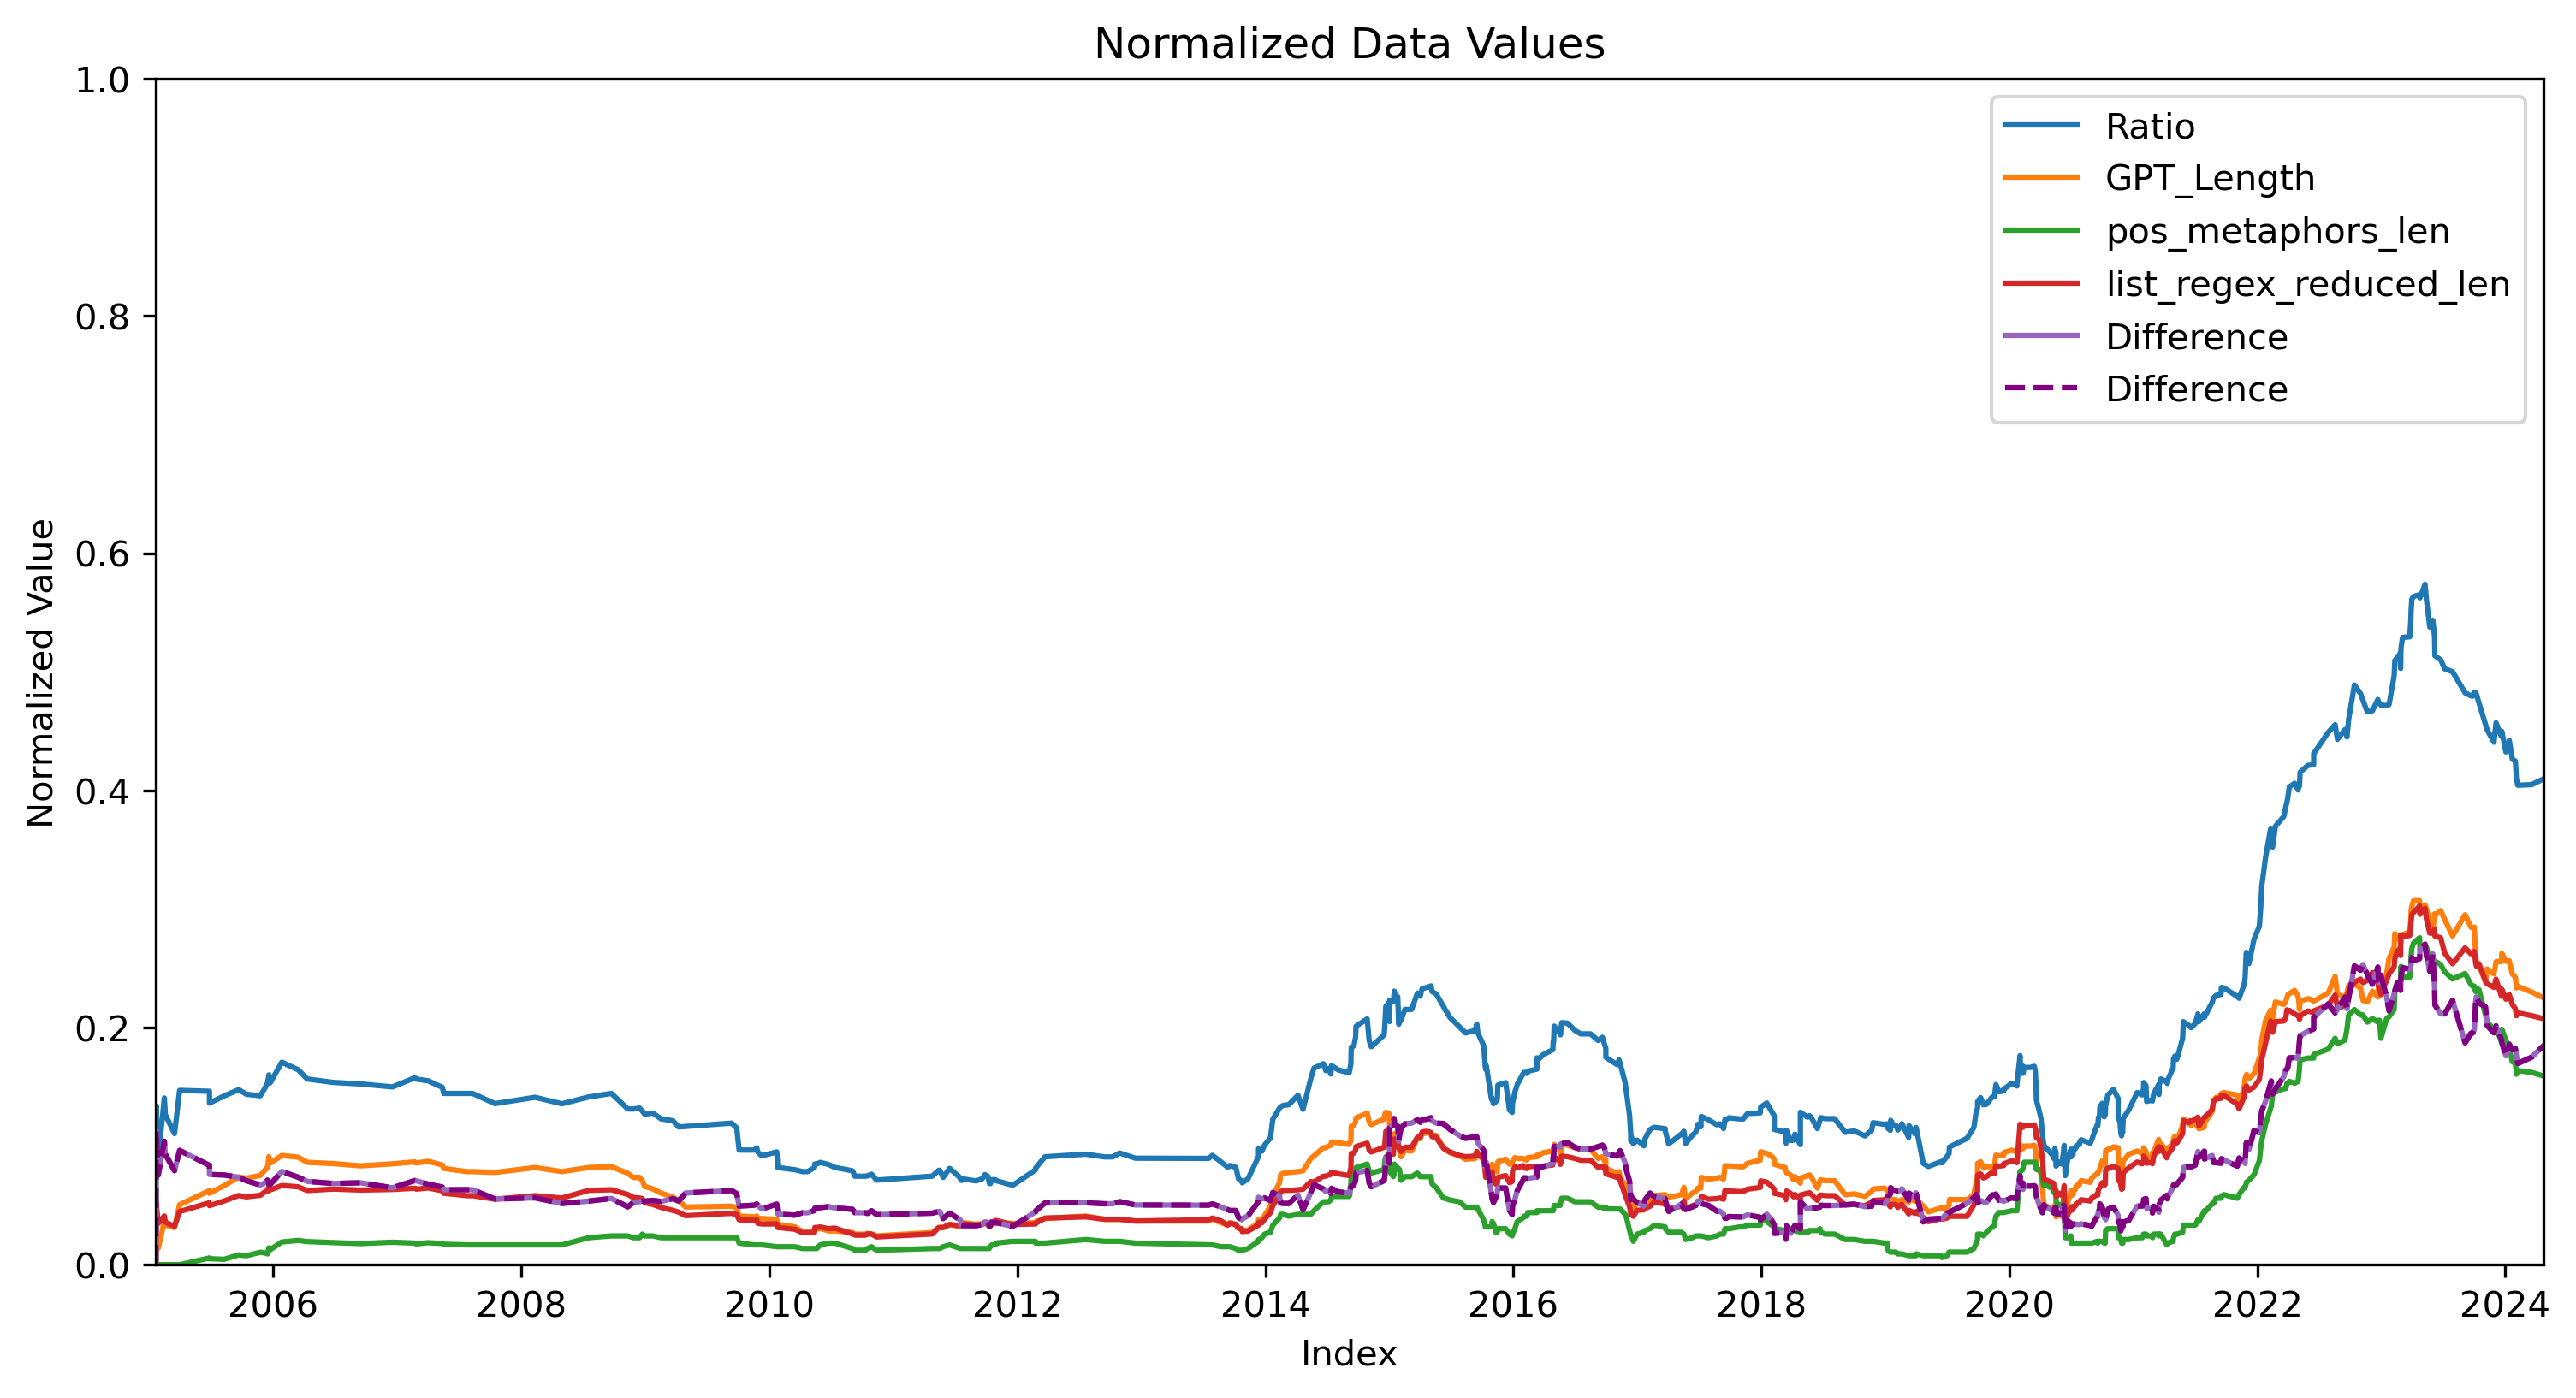

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Smooth plot:
def moving_average(data, window_size):
    return data.rolling(window=window_size, min_periods=1).mean()

plt.figure(figsize=(12, 6), dpi=300)
# Apply moving average to smooth the lines
window_size = 30

for column in df_normalized.columns:
    plt.plot(df_normalized.index, moving_average(df_normalized[column], window_size), label=column)

# Customize the plot
plt.xlabel('Index')
plt.ylabel('Normalized Value')
plt.title('Normalized Data Values')
plt.legend()
# Set the x-axis and y-axis limits
plt.xlim(df_normalized.index.min(), df_normalized.index.max())
plt.ylim(0, 1)

# Display the plot
plt.show()


C:\Users\School\AppData\Local\Temp\ipykernel_26600\567339928.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')
C:\Users\School\AppData\Local\Temp\ipykernel_26600\567339928.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color=cmap(norm(diff[i])))


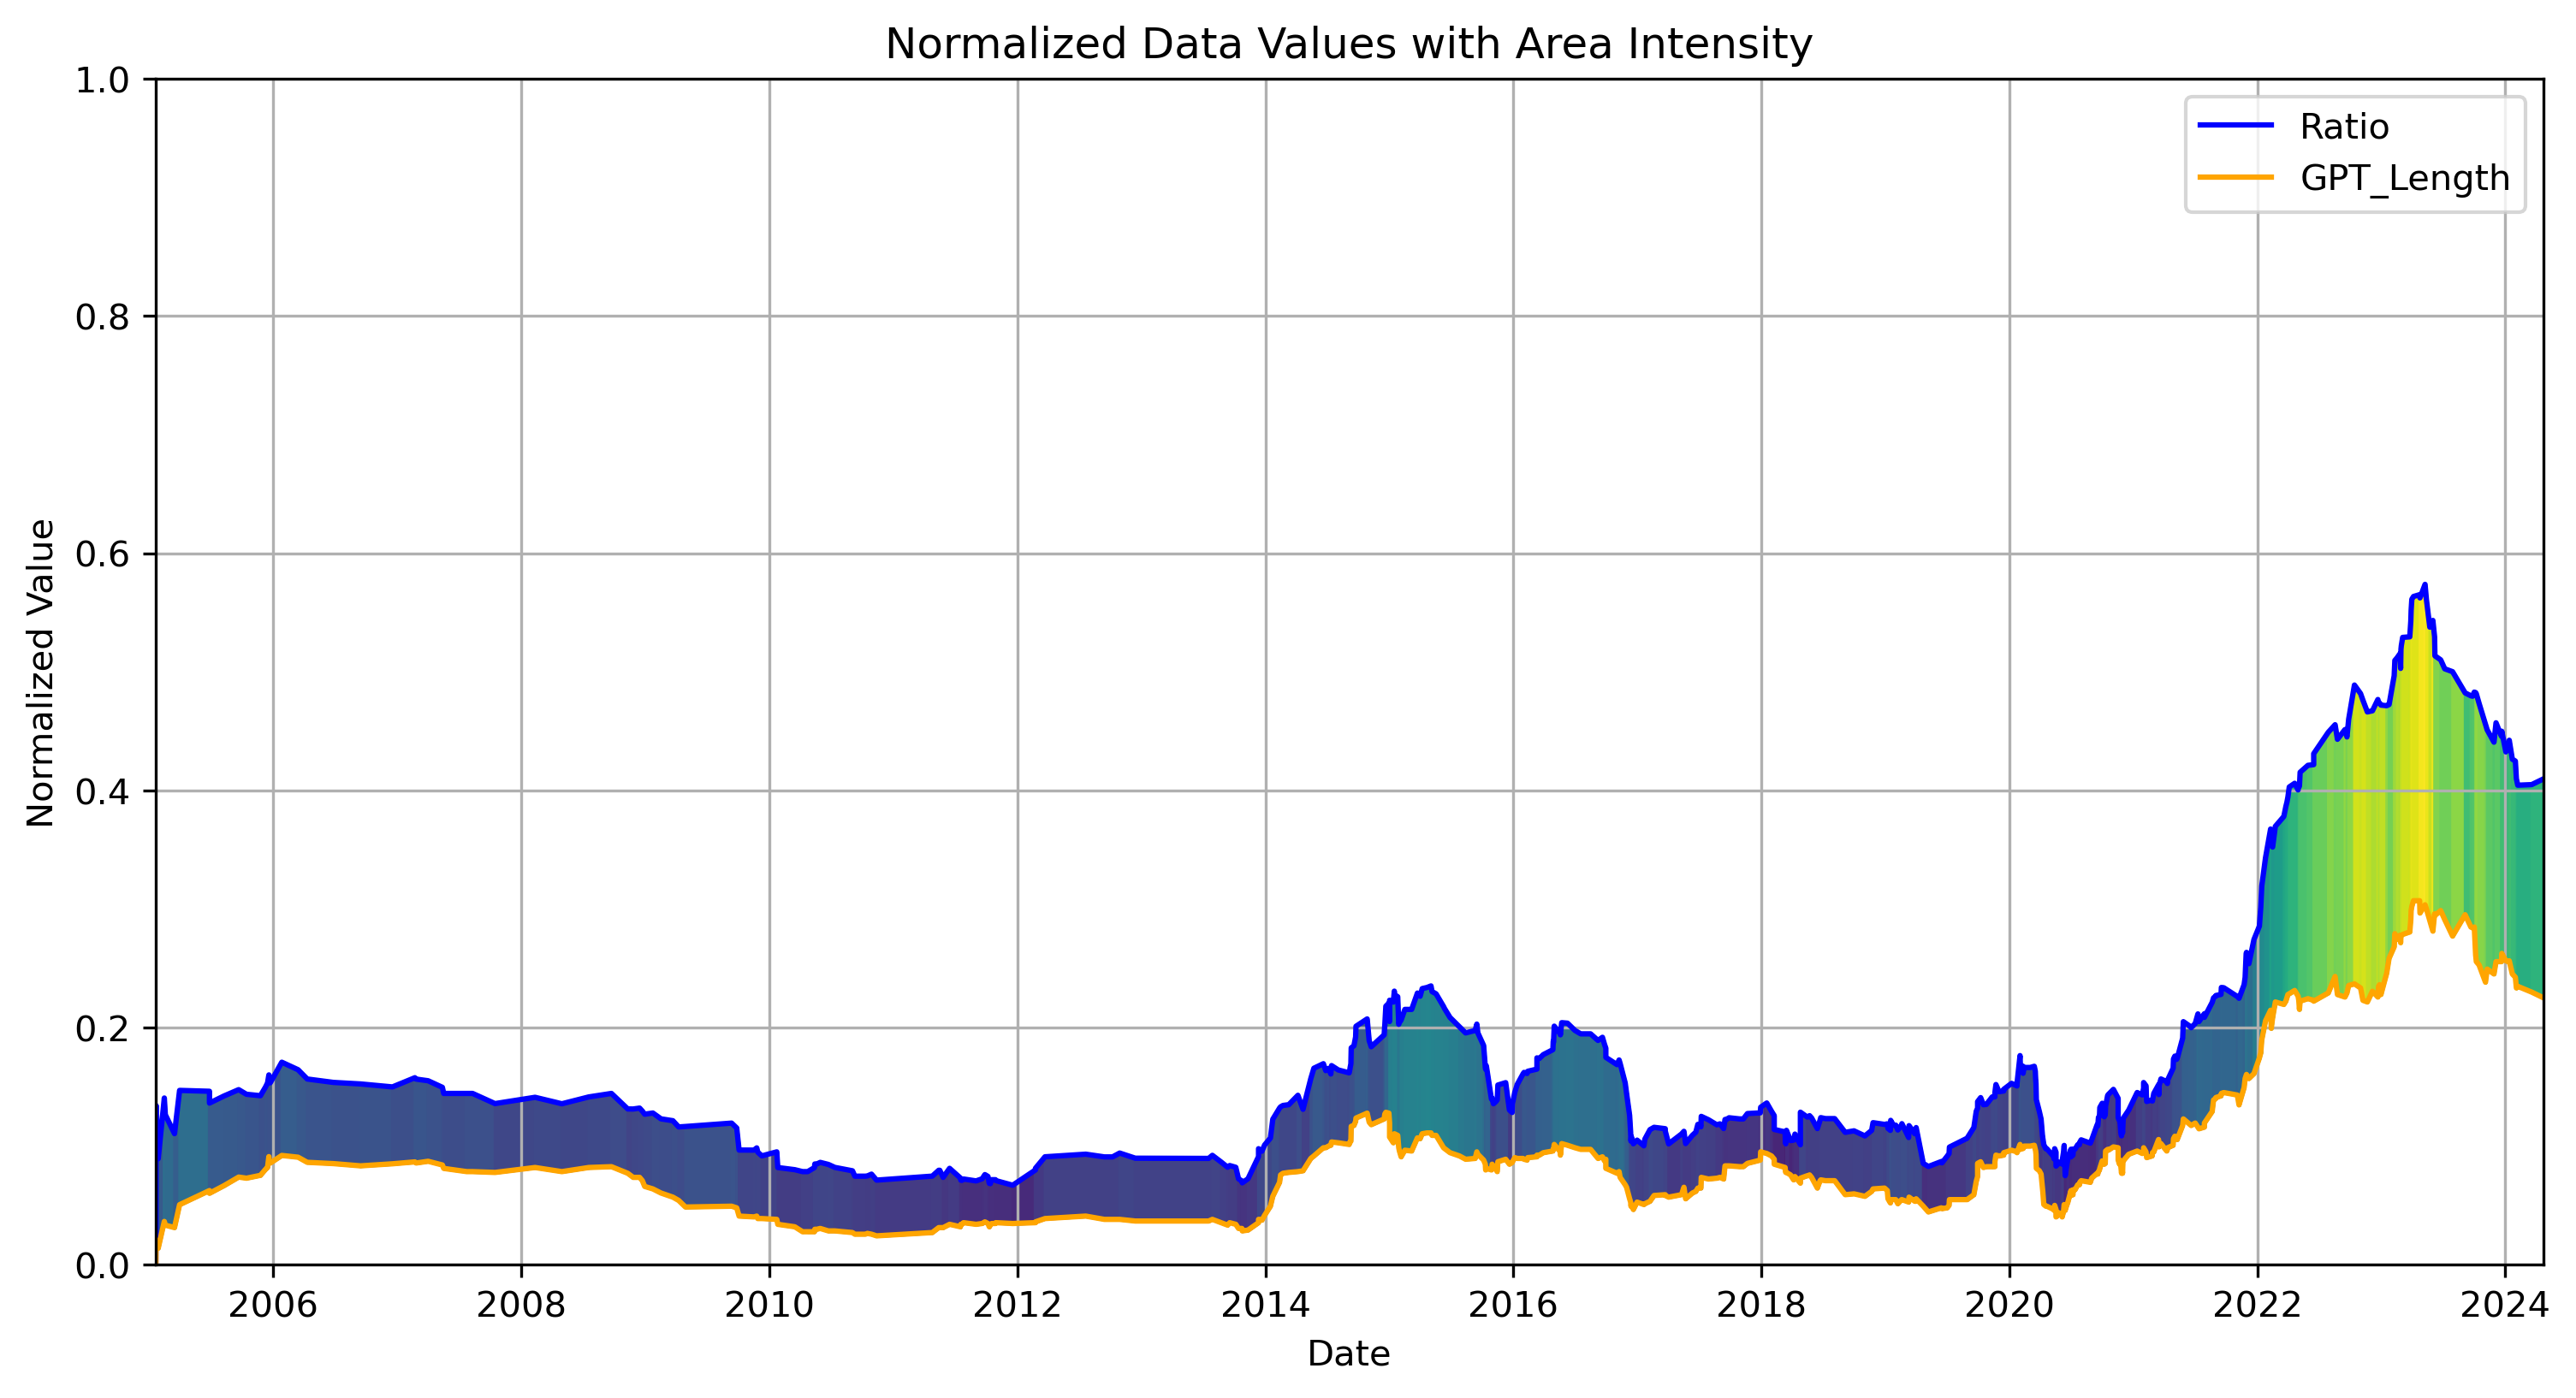

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm

plt.figure(figsize=(12, 6), dpi=300)
# Apply moving average to smooth the lines
window_size = 30

ratio_smoothed = moving_average(df_normalized['Ratio'], window_size)
gpt_length_smoothed = moving_average(df_normalized['GPT_Length'], window_size)

# Calculate the absolute difference for coloring
diff = np.abs(ratio_smoothed - gpt_length_smoothed)
norm = Normalize(vmin=diff.min(), vmax=diff.max())
cmap = cm.get_cmap('viridis')

# Plot the smoothed lines
plt.plot(df_normalized.index, ratio_smoothed, label='Ratio', color='blue')
plt.plot(df_normalized.index, gpt_length_smoothed, label='GPT_Length', color='orange')

# Fill the area between the lines with varying color intensity
for i in range(len(df_normalized) - 1):
    plt.fill_between(df_normalized.index[i:i+2],
                     ratio_smoothed[i:i+2],
                     gpt_length_smoothed[i:i+2],
                     color=cmap(norm(diff[i])))

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.title('Normalized Data Values with Area Intensity')
plt.legend()
plt.grid(True)

# Set the x-axis and y-axis limits
plt.xlim(df_normalized.index.min(), df_normalized.index.max())
plt.ylim(0, 1)

# Display the plot
plt.show()


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


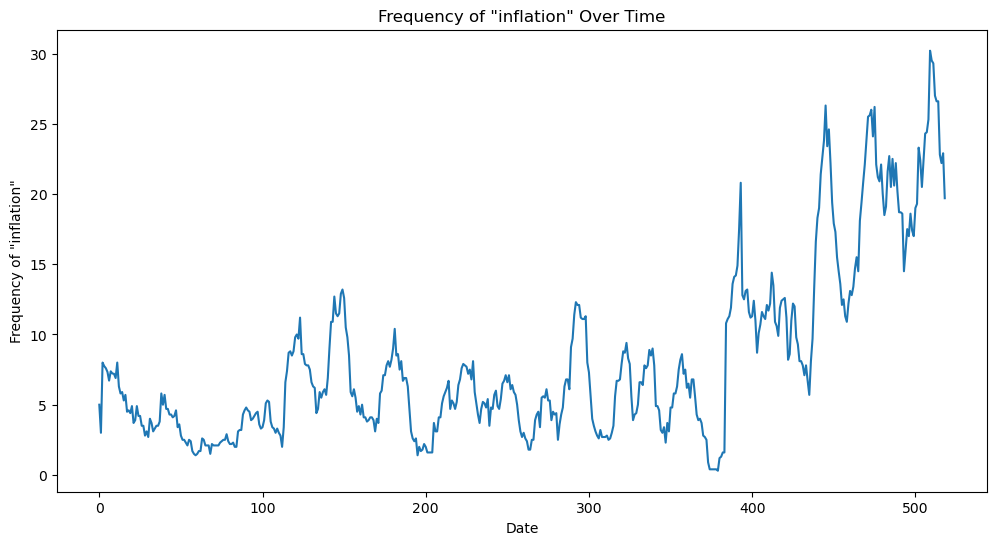

In [28]:
# Plot of Frequency of "inflation" Over Time with moving average
plt.figure(figsize=(12, 6))
window_size = 10
sns.lineplot(moving_average(df['Frequency'], window_size))
plt.title('Frequency of "inflation" Over Time')
plt.xlabel('Date')
plt.ylabel('Frequency of "inflation"')
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


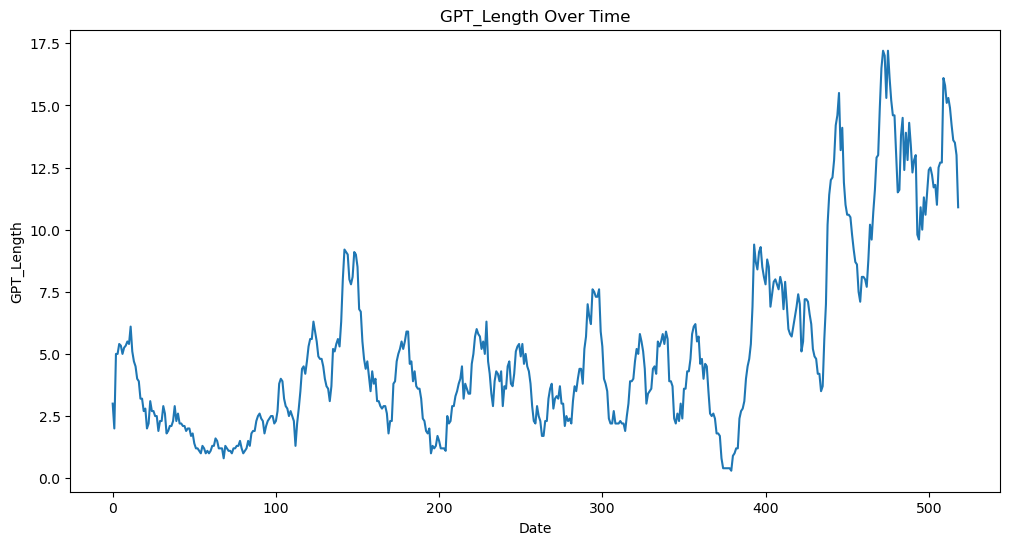

In [29]:
# Plot of GPT_Length
plt.figure(figsize=(12, 6))
window_size = 10
sns.lineplot(moving_average(df['GPT_Length'], window_size))
plt.title('GPT_Length Over Time')
plt.xlabel('Date')
plt.ylabel('GPT_Length')
plt.show()

## Sentiment Analysis (using the Metaphors)

In [30]:
# Load the sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")
# "text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
# TODO: Can try other models: https://huggingface.co/models?pipeline_tag=text-classification&sort=trending

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [31]:
# Function to get sentiment scores for each sentence
def get_sentiment_scores(sentences):
    scores = []
    for sentence in sentences:
        result = sentiment_pipeline(sentence)
        scores.append(result[0]['score'] if result else 0)
    return scores

# Apply the function to each row in the dataframe
df['Sentiment_Scores'] = df['Sentence_GPT'].apply(get_sentiment_scores)

In [32]:
# Number of sentence_gpt with empty lists
empty_lists = df['Sentiment_Scores'].apply(len) == 0
print(f'Number of empty lists: {empty_lists.sum()}')   
# Number of sentiment scores with empty lists
empty_lists = df['Sentiment_Scores'].apply(len) == 0
print("Number of sentiment scores with empty lists: ", empty_lists.sum())

Number of empty lists: 118
Number of sentiment scores with empty lists:  118


c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a f

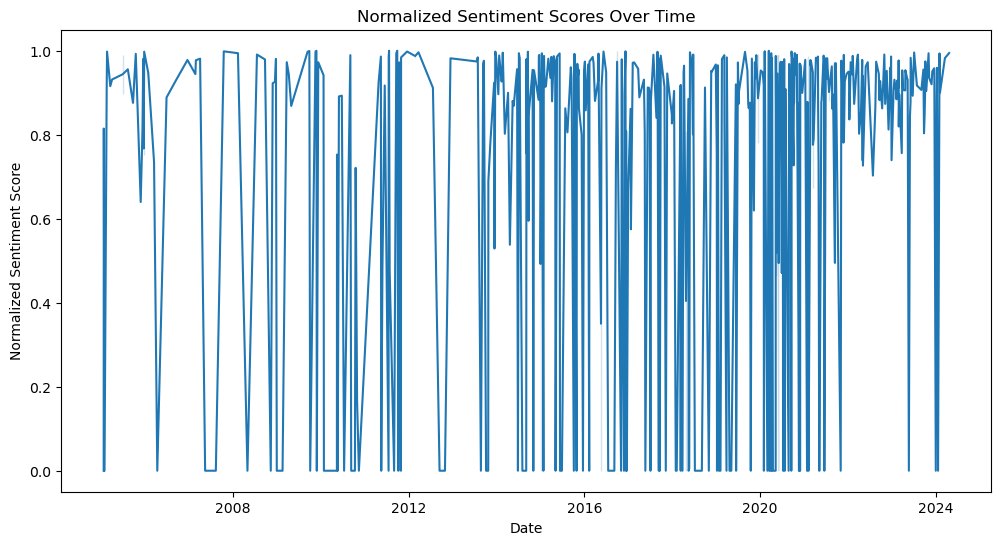

In [33]:
# average sentiment score
df['Average_Sentiment'] = df['Sentiment_Scores'].apply(np.mean)

# standard deviation of sentiment scores
df['Sentiment_Std'] = df['Sentiment_Scores'].apply(np.std)

# Normalize the sentiment scores
df['Normalized_Sentiment'] = (df['Average_Sentiment'] - df['Average_Sentiment'].min()) / (df['Average_Sentiment'].max() - df['Average_Sentiment'].min())
df['Normalized_Sentiment'] = df['Normalized_Sentiment'].fillna(0)

# Plot the normalized sentiment scores
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Date', y='Normalized_Sentiment')
plt.title('Normalized Sentiment Scores Over Time')
plt.xlabel('Date')
plt.ylabel('Normalized Sentiment Score')
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


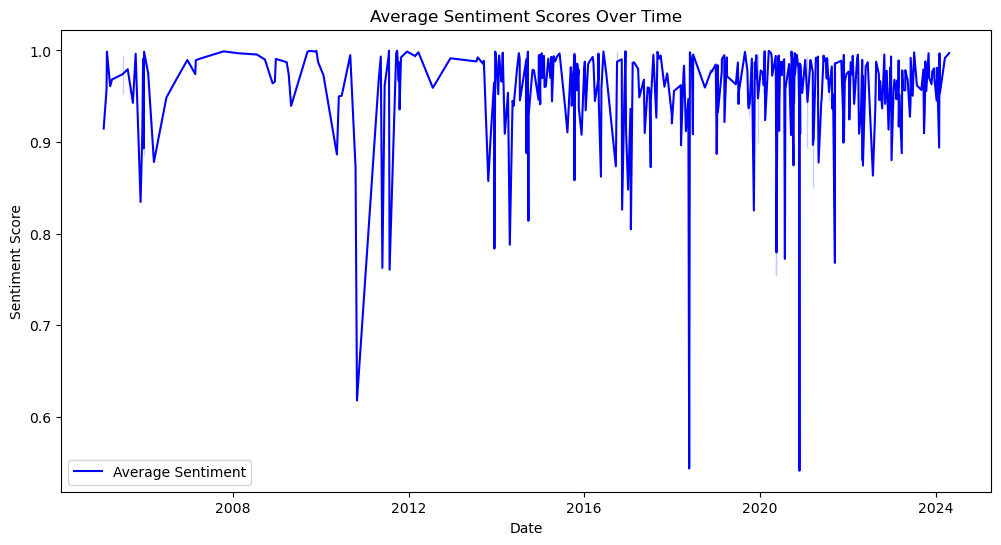

In [34]:
# Plot the average sentiment score over time and the standard deviation
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Date', y='Average_Sentiment', color='blue', label='Average Sentiment')
plt.title('Average Sentiment Scores Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


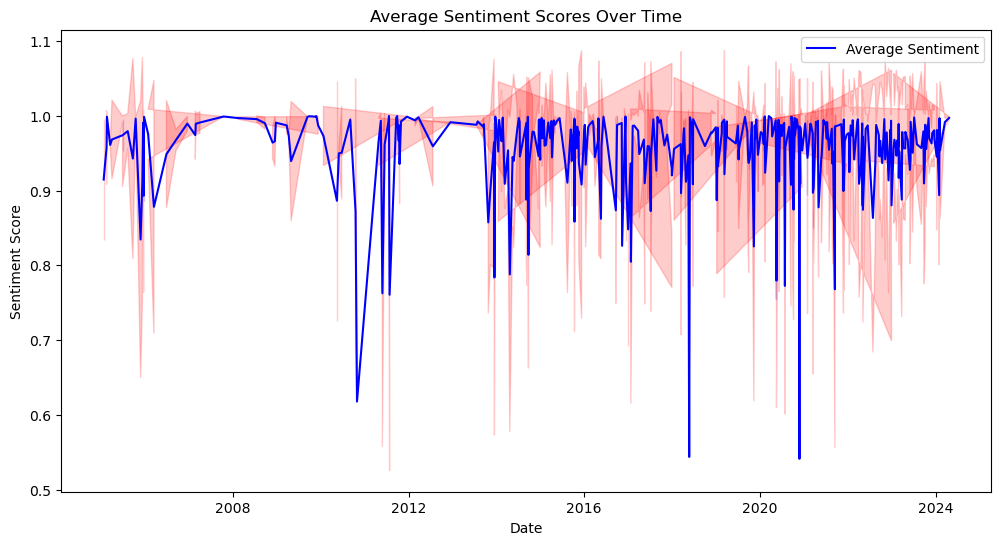

In [35]:
# Plot the average sentiment score over time and the standard deviation as confidence interval
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Date', y='Average_Sentiment', color='blue', label='Average Sentiment')
plt.fill_between(df['Date'], df['Average_Sentiment'] - df['Sentiment_Std'], df['Average_Sentiment'] + df['Sentiment_Std'], color='red', alpha=0.2)
plt.title('Average Sentiment Scores Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.show()

C:\Users\School\AppData\Local\Temp\ipykernel_21108\2745138746.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')
C:\Users\School\AppData\Local\Temp\ipykernel_21108\2745138746.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap))


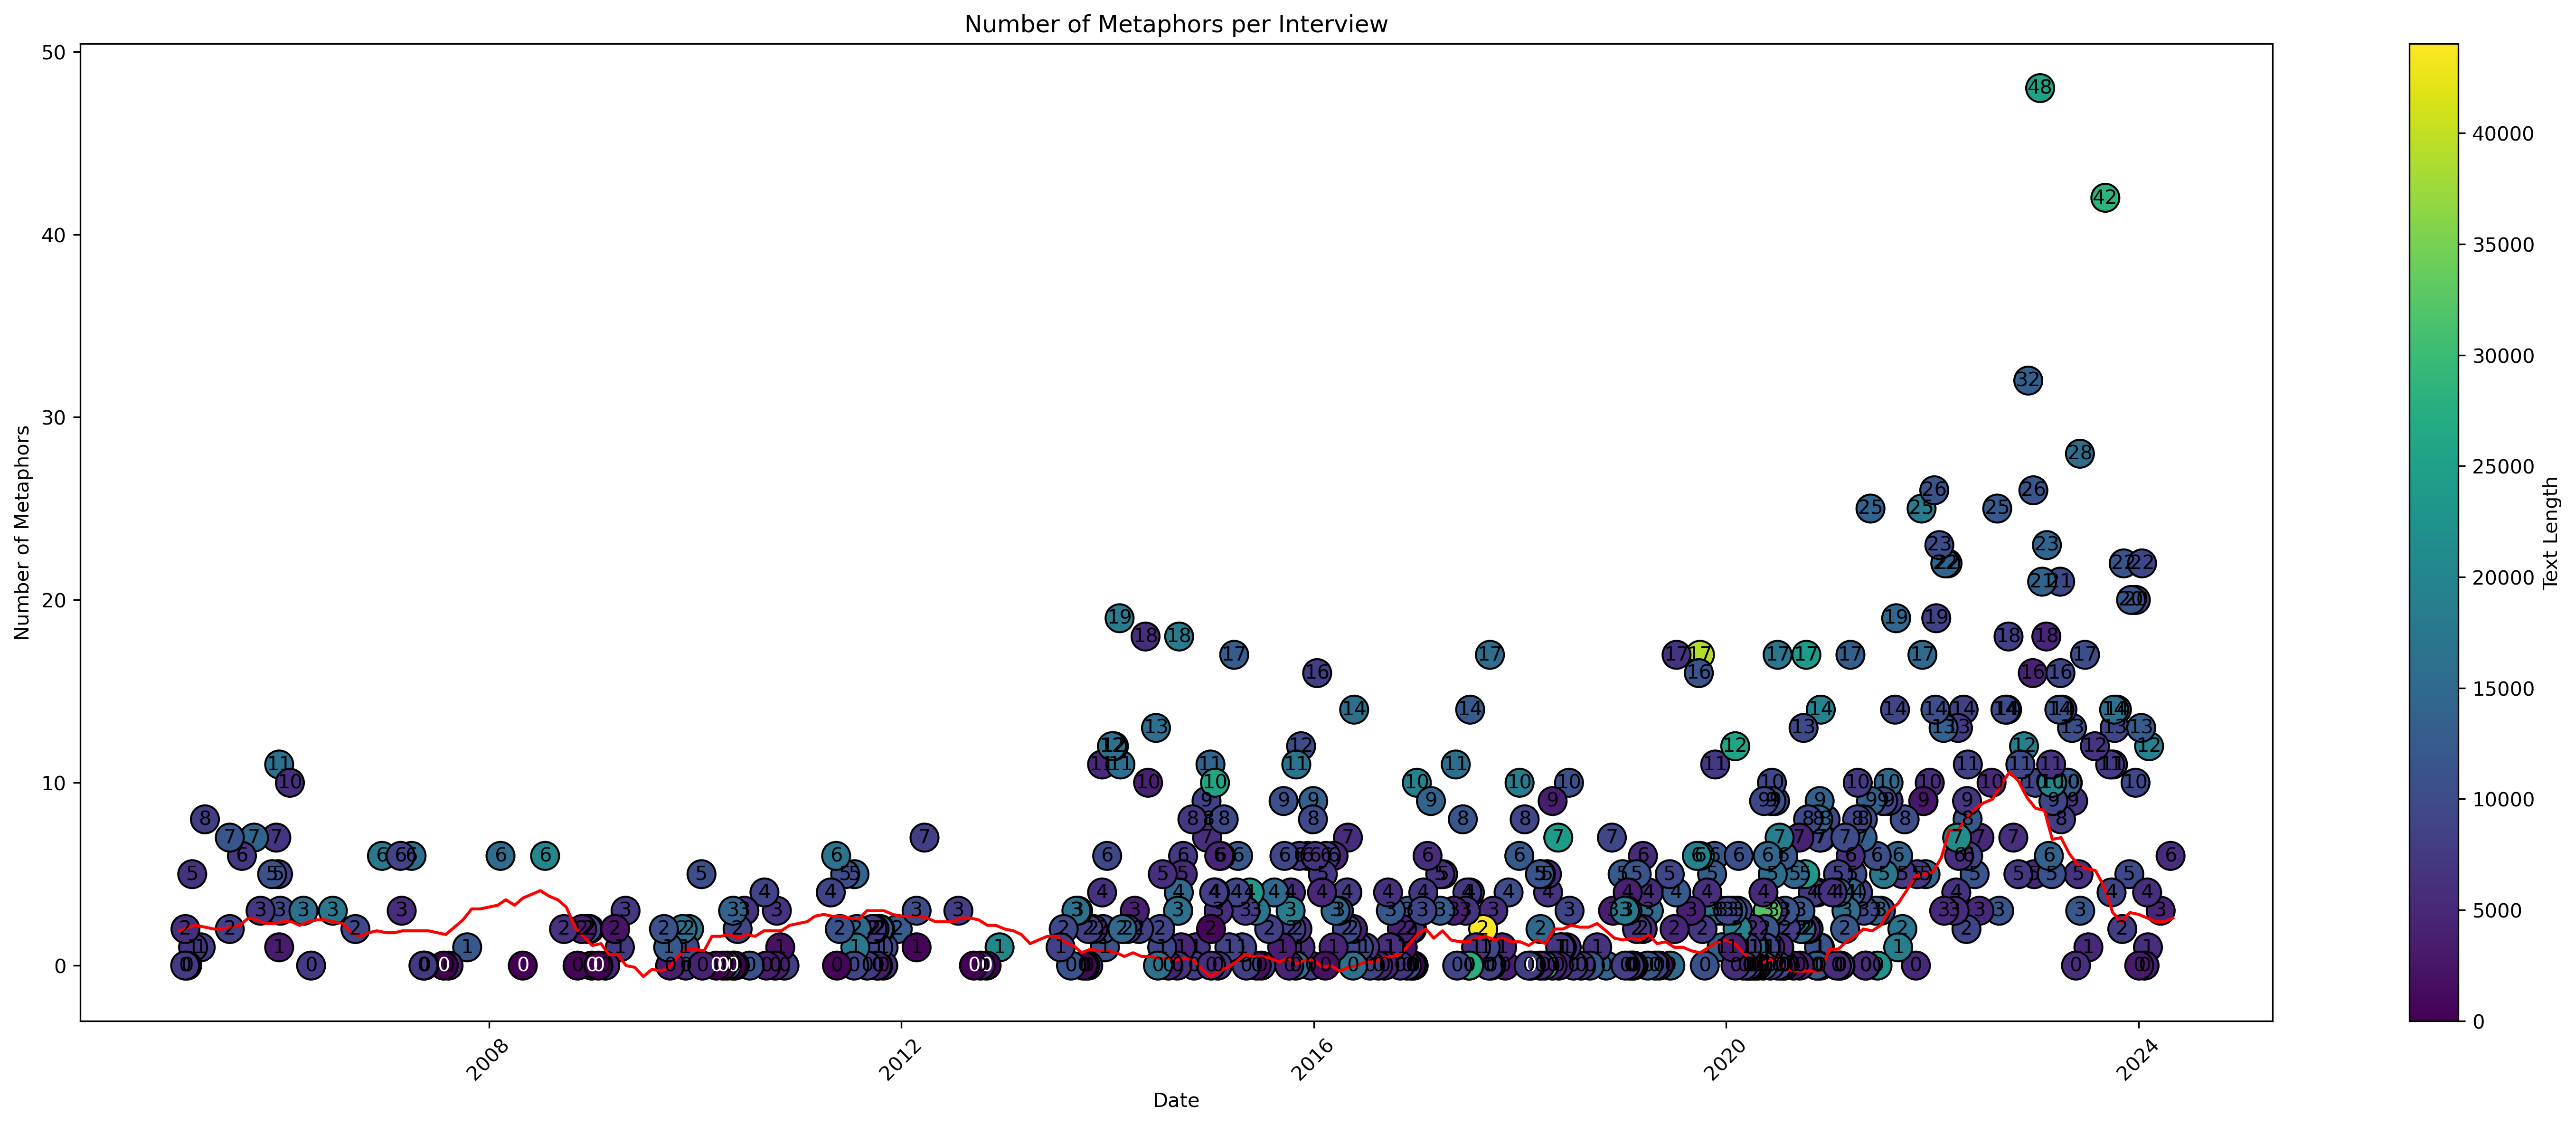

In [36]:
# Defining colors based on text length
norm = mcolors.Normalize(vmin=df['text_length'].min(), vmax=df['text_length'].max())
cmap = plt.cm.get_cmap('viridis')

# Create scatter plot
plt.figure(figsize=(20, 8), dpi=300)
sc = plt.scatter(df['Date'], df['GPT_Length'], c=df['text_length'], cmap=cmap, norm=norm, s=200, edgecolors='k')

# Add text length colorbar
cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_label('Text Length')

# Add metaphor count labels inside the points
for i, row in df.iterrows():
    plt.text(row['Date'], row['GPT_Length'], str(row['GPT_Length']), ha='center', va='center', color='white' if row['text_length'] < 0.5 else 'black')

# Plot line for OBS_VALUE from df2
plt.plot(df2['TIME_PERIOD'], df2['OBS_VALUE'], color='red', label='OBS_VALUE')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Number of Metaphors')
plt.title('Number of Metaphors per Interview')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

C:\Users\School\AppData\Local\Temp\ipykernel_21108\3220626128.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')
C:\Users\School\AppData\Local\Temp\ipykernel_21108\3220626128.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap))


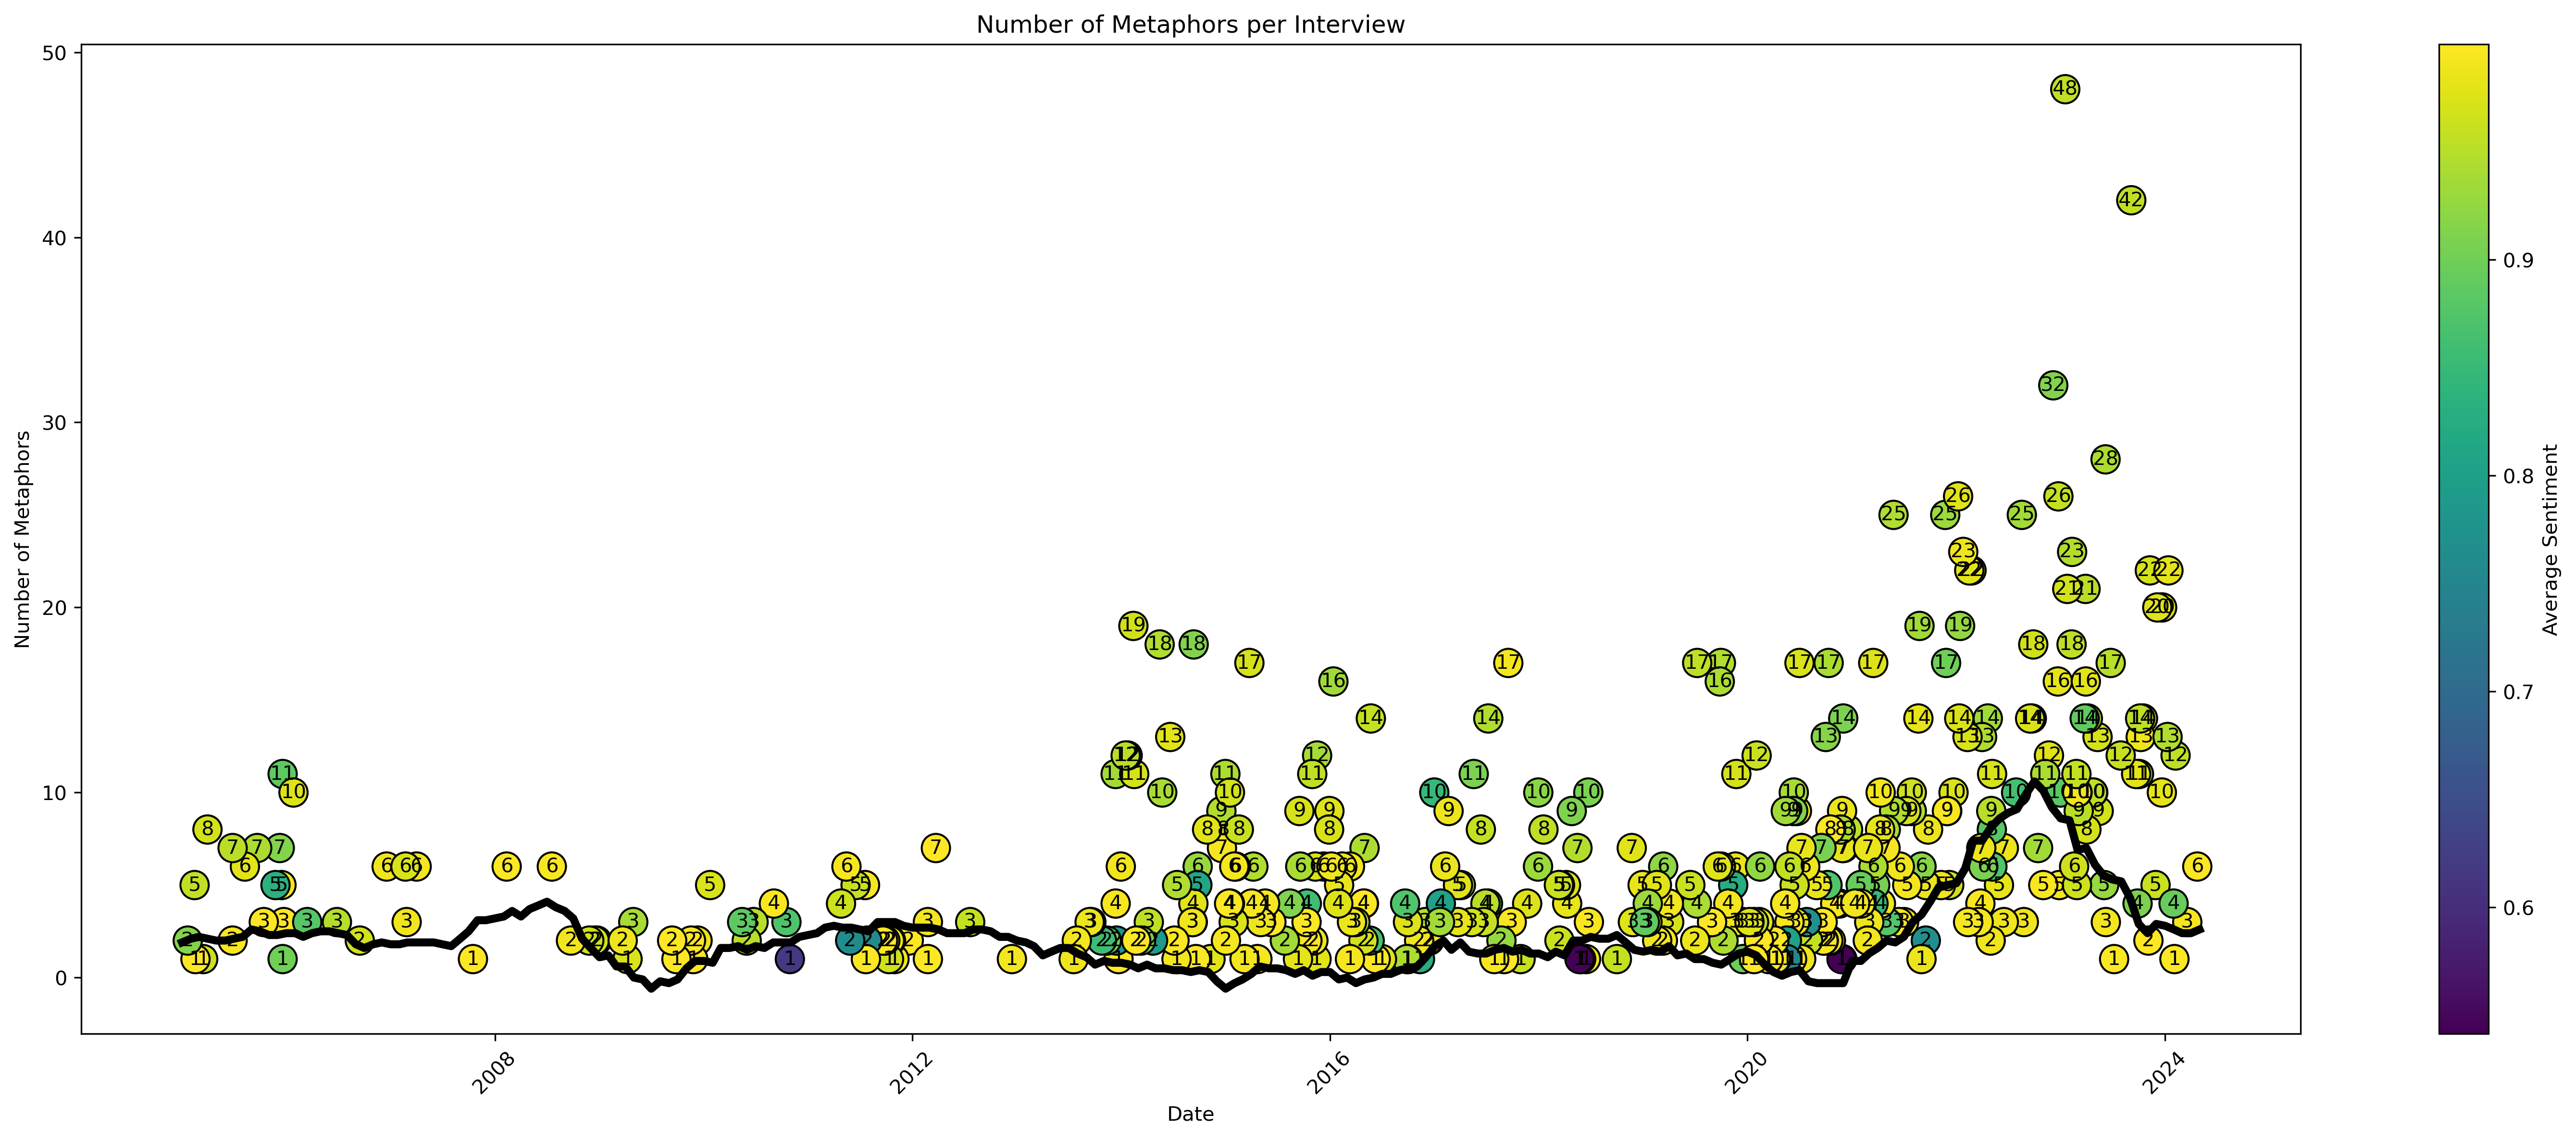

In [50]:
# Filter out rows where GPT_Length is 0
df_filtered = df[df['GPT_Length'] != 0]

# Defining colors based on text length
norm = mcolors.Normalize(vmin=df_filtered['Average_Sentiment'].min(), vmax=df_filtered['Average_Sentiment'].max())
cmap = plt.cm.get_cmap('viridis')

# Create scatter plot
plt.figure(figsize=(20, 8), dpi=300)
sc = plt.scatter(df_filtered['Date'], df_filtered['GPT_Length'], c=df_filtered['Average_Sentiment'], cmap=cmap, norm=norm, s=200, edgecolors='k')

# Add text length colorbar
cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_label('Average Sentiment')

# Add metaphor count labels inside the points
for i, row in df_filtered.iterrows():
    plt.text(row['Date'], row['GPT_Length'], str(row['GPT_Length']), ha='center', va='center', color='white' if row['Average_Sentiment'] < 0.5 else 'black')

# Plot line for OBS_VALUE from df2 with a thicker line
plt.plot(df2['TIME_PERIOD'], df2['OBS_VALUE'], color='black', label='OBS_VALUE', linewidth=4)

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Number of Metaphors')
plt.title('Number of Metaphors per Interview')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()


C:\Users\School\AppData\Local\Temp\ipykernel_21108\1775893404.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')
C:\Users\School\AppData\Local\Temp\ipykernel_21108\1775893404.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap))


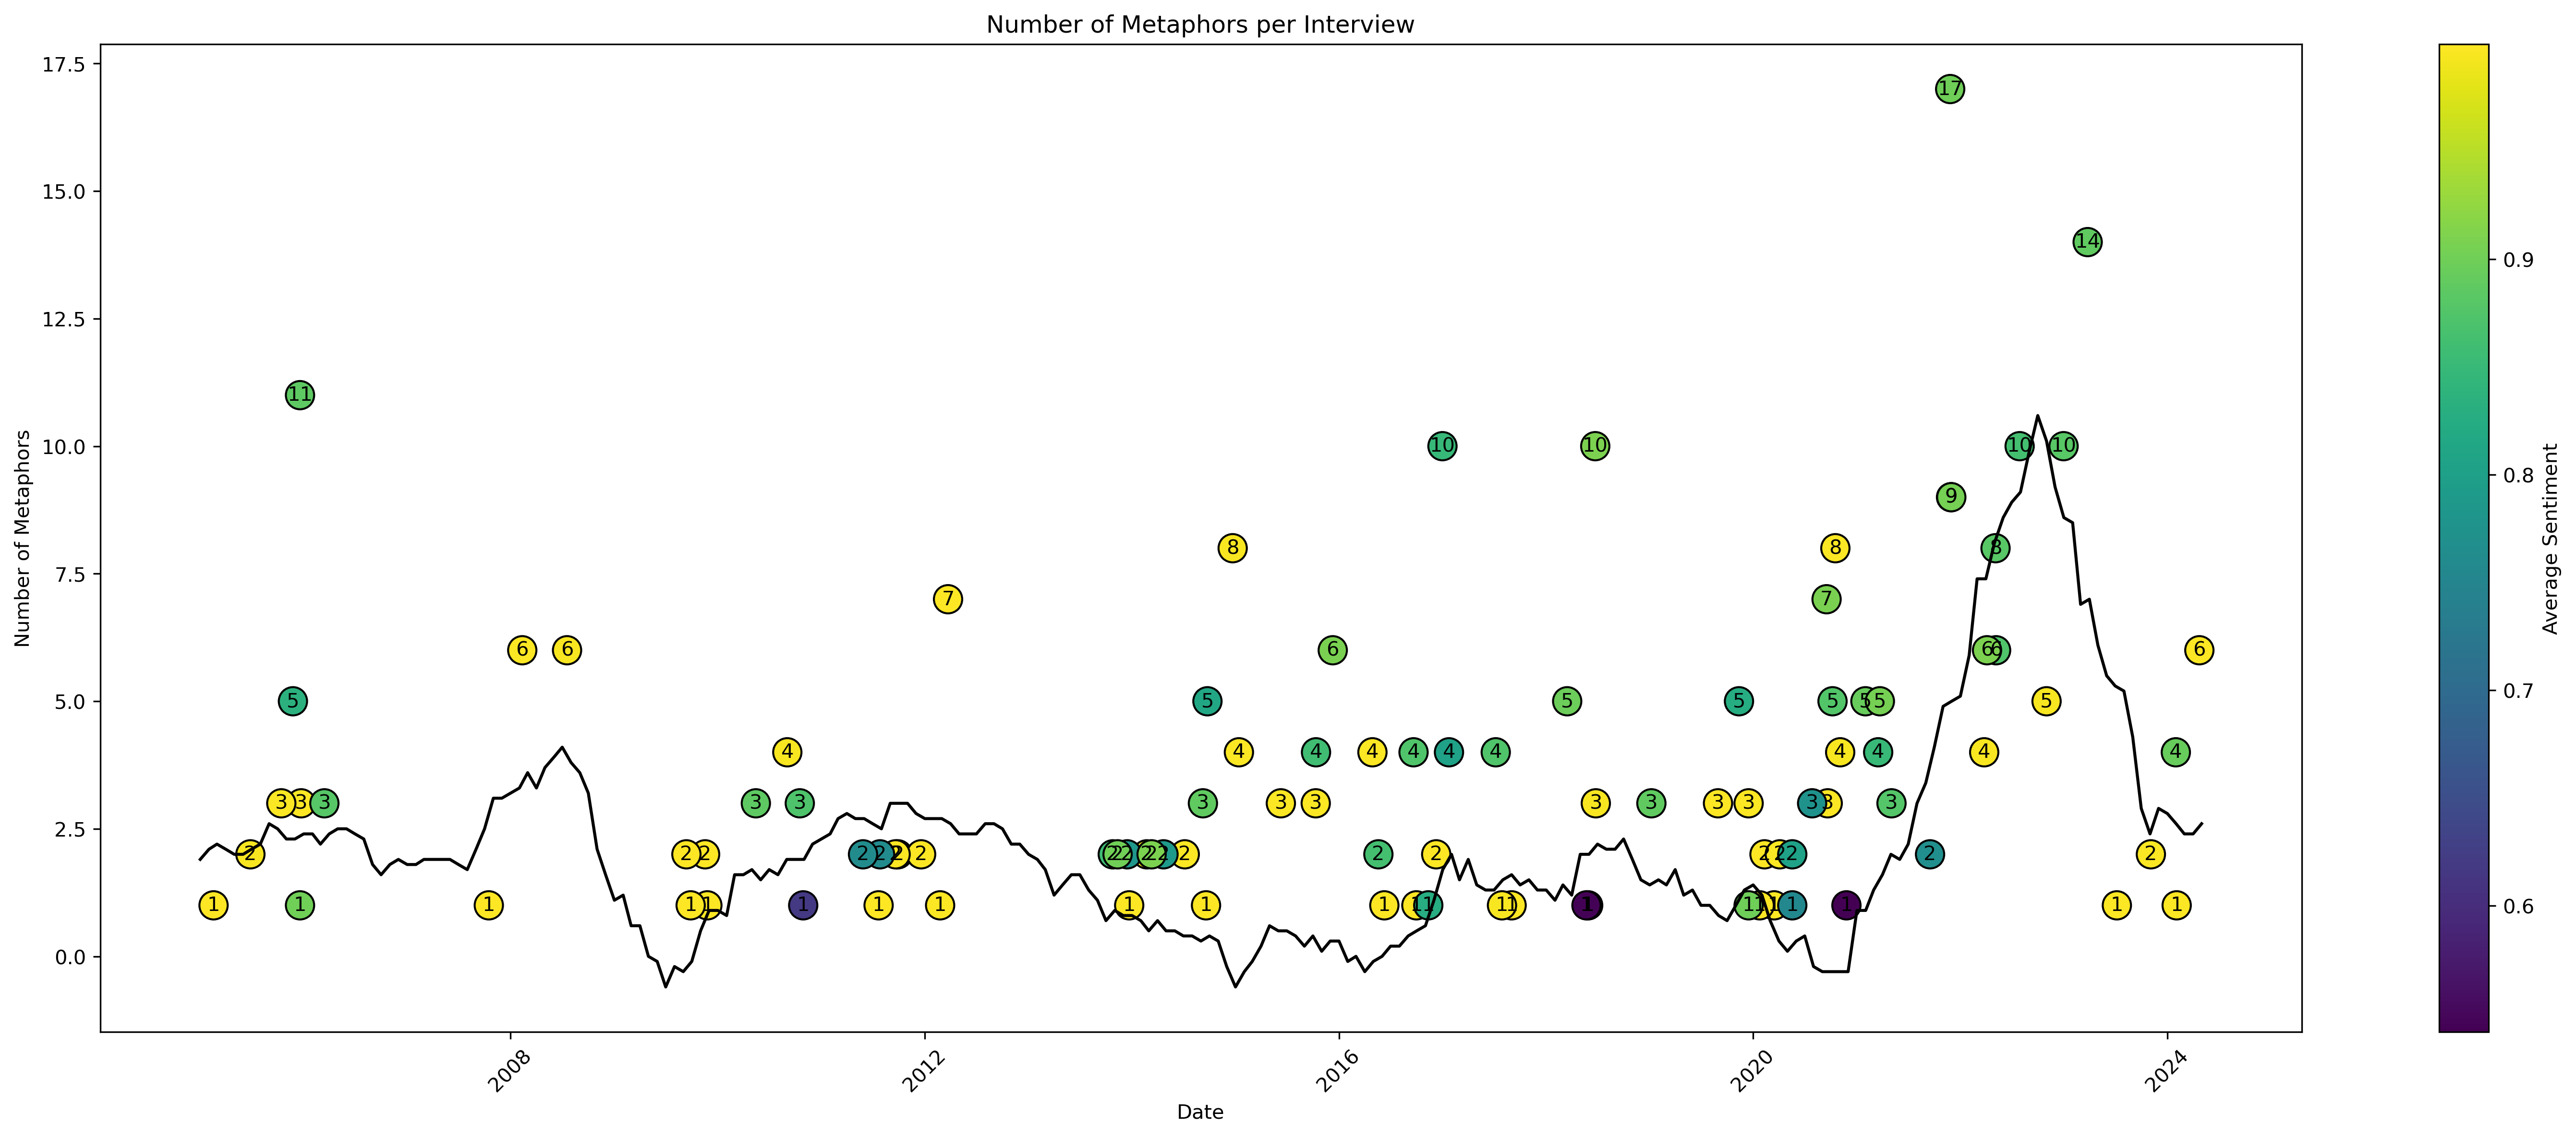

In [61]:
# Filter the top 10 and bottom 10 average sentiments
top_10 = df.nlargest(50, 'Average_Sentiment')
bottom_10 = df.nsmallest(50, 'Average_Sentiment')
filtered_df = pd.concat([top_10, bottom_10])

# Normalize the color based on the filtered data
norm = mcolors.Normalize(vmin=filtered_df['Average_Sentiment'].min(), vmax=filtered_df['Average_Sentiment'].max())
cmap = plt.cm.get_cmap('viridis')

# Create scatter plot
plt.figure(figsize=(20, 8), dpi=300)
sc = plt.scatter(filtered_df['Date'], filtered_df['GPT_Length'], c=filtered_df['Average_Sentiment'], cmap=cmap, norm=norm, s=200, edgecolors='k')

# Add text length colorbar
cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_label('Average Sentiment')

# Add metaphor count labels inside the points
for i, row in filtered_df.iterrows():
    plt.text(row['Date'], row['GPT_Length'], str(row['GPT_Length']), ha='center', va='center', color='white' if row['Average_Sentiment'] < 0.5 else 'black')

# Plot line for OBS_VALUE from df2 (make sure df2 is already loaded and has the required columns)
plt.plot(df2['TIME_PERIOD'], df2['OBS_VALUE'], color='black', label='OBS_VALUE')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Number of Metaphors')
plt.title('Number of Metaphors per Interview')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()


In [38]:
df.head()

Unnamed: 0       Date                                              Media  \
0           0 2005-12-23                         Interview with Der Spiegel   
1           1 2005-12-19                  Interview with Hospodářské Noviny   
2           2 2005-12-19  Interview with Financial Times and Financial T...   
3           3 2005-12-15                         Interview with Paris Match   
4           4 2005-12-09                           Interview in Il Giornale   

                Member                                               Link  \
0  Jean-Claude Trichet  https://www.ecb.europa.eu/press/inter/date/200...   
1         Otmar Issing  https://www.ecb.europa.eu/press/inter/date/200...   
2      Lucas Papademos  https://www.ecb.europa.eu/press/inter/date/200...   
3  Jean-Claude Trichet  https://www.ecb.europa.eu/press/inter/date/200...   
4  Lorenzo Bini Smaghi  https://www.ecb.europa.eu/press/inter/date/200...   

             Information                                          Questions  \
0  Information not found  SPIEGEL: Monsieur Trichet, any concrete uttera...   
1  Information not found  The new EU member states want to adopt the eur...   
2  Information not found  Mr Papademos, you have responsibility as ECB V...   
3  Information not found  Paris Match. After two uneventful years at the...   
4  Information not found  However, Europe’s politicians, with few except...   

                                             Answers Metaphors  \
0  The publication of the translation was authori...       NaN   
1  These questions are all closely related to eac...       NaN   
2  A comparison of the risks involved when short-...       NaN   
3  The publication of the translation was authori...       NaN   
4  By Angelo Allegri, our correspondent in Frankf...       NaN   

  Metaphors Sentence  ...  Frequency Sentences_len  \
0                NaN  ...          5             3   
1                NaN  ...          1             1   
2                NaN  ...         18            11   
3                NaN  ...          7             5   
4                NaN  ...          7             7   

                                        Sentence_GPT  \
0  [we will in the future take the decisions that...   
1  [we are not confronted with deflation but with...   
2  [if longterm interest rates remain at a low le...   
3  [you are exaggerating the increase in the cost...   
4  [the rise has helped to keep inflation expecta...   

                                        Category_GPT GPT_Length     Ratio  \
0                    ['machine', 'disease', 'plant']          3  0.000534   
1                                        ['warfare']          1  0.000312   
2  ['orientation', 'orientation', 'plant', 'orien...         11  0.001109   
3  ['plant', 'disease', 'other', 'disease', 'mach...          5  0.000855   
4  ['orientation', 'orientation', 'orientation', ...          7  0.001035   

                                    Sentiment_Scores  Average_Sentiment  \
0  [0.9983261227607727, 0.9980594515800476, 0.999...           0.998641   
1                               [0.9001441597938538]           0.900144   
2  [0.9995494484901428, 0.7444977164268494, 0.908...           0.885917   
3  [0.9920231103897095, 0.989870011806488, 0.9761...           0.990793   
4  [0.9903539419174194, 0.9070272445678711, 0.996...           0.914485   

   Sentiment_Std Normalized_Sentiment  
0       0.000643             0.997650  
1       0.000000             0.782767  
2       0.121692             0.751729  
3       0.008019             0.980527  
4       0.163515             0.814052  

[5 rows x 32 columns]

In [794]:
def mean_of_lists(lst):
    lst = [item for item in lst if isinstance(item, list) and len(item) > 0]
    return np.mean(lst) if len(lst) > 0 else np.nan

# Group by month and calculate means, handling NA
monthly_means = df.groupby(df['Date'].dt.to_period('M')).agg({
    'Ratio': 'mean',
    'Sentiment_Scores': lambda x: mean_of_lists(x),
    'Average_Sentiment': 'mean',
    'GPT_Length': 'mean',
    'Sentiment_Std': 'mean'
}).fillna(df.mean())

# Create a new DataFrame with monthly dates as index
monthly_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='MS')
monthly_data = pd.DataFrame(index=monthly_dates)

# Step 4: Populate the new DataFrame with monthly mean values
monthly_data['Ratio'] = monthly_means['Ratio']
monthly_data['Sentiment_Scores'] = monthly_means['Sentiment_Scores']
monthly_data['Average_Sentiment'] = monthly_means['Average_Sentiment']
monthly_data['GPT_Length'] = monthly_means['GPT_Length']
monthly_data['Sentiment_Std'] = monthly_means['Sentiment_Std']

# Display the resulting DataFrame
monthly_data.head()


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [807]:
import pandas as pd
import numpy as np


# Step 1: Convert 'Date' column to datetime if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Step 2: Define a function to calculate mean of lists
def mean_of_lists(lst):
    lst = [item for item in lst if isinstance(item, list) and len(item) > 0]
    return np.mean(np.concatenate(lst)) if len(lst) > 0 else 0

# Step 3: Group by month and calculate means, handling lists and NA
monthly_means = df.groupby(df['Date'].dt.to_period('M')).agg({
    'Ratio': 'mean',
    'Average_Sentiment': 'mean',
    'GPT_Length': 'mean',
    'Sentiment_Std': 'mean'
})

# Step 4: Create a new DataFrame with monthly dates as index
monthly_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='MS')
monthly_data = pd.DataFrame(index=monthly_dates)

# Step 5: Merge monthly_means with monthly_data on the date index
monthly_data = monthly_data.merge(monthly_means, how='left', left_index=True, right_index=True)


# Display the resulting DataFrame
print(monthly_data)


TypeError: Addition/subtraction of integers and integer-arrays with Timestamp is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

In [805]:
monthly_means

Ratio  Average_Sentiment  GPT_Length  Sentiment_Std
Date                                                           
2005-01  0.000379           0.914781    0.666667       0.080762
2005-02  0.000771           0.978256    3.000000       0.024726
2005-03  0.000839           0.964673    4.500000       0.026251
2005-06  0.000418           0.974001    4.500000       0.025778
2005-08  0.000832           0.979472    6.000000       0.023256
...           ...                ...         ...            ...
2023-12  0.002359           0.975848   16.666667       0.036042
2024-01  0.001460           0.940138    7.800000       0.073453
2024-02  0.001072           0.975378    6.500000       0.045801
2024-03  0.002182           0.991687    3.000000       0.004866
2024-04  0.002332           0.997189    6.000000       0.001755

[184 rows x 4 columns]

In [ ]:
# TODO: Total number of metaphors labeled, total number of sentences, total number of Frequency
# TODO: Check Metaphors and Metaphors Sentence have the same length